In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

In [3]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = ""
        self.ActivityTokensVerb = ""
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, self.ActivityTokensVerb ,self.ActivityTokensChunk))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = ""
        self.ActivityTokensVerb = ""

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

In [4]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], "", 0)
        OshaCaseItems.append(TempCaseItem)
        
def explore(text):   
    tokens = word_tokenize(text)
    if (len(tokens)>0):
        fd = nltk.FreqDist(tokens)
        fd.most_common(25)
        fd.plot(25)
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        wc = WordCloud(background_color="white").generate(text)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    else:
        print("explore function no data")

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    MsiaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)

def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it

In [5]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
#    print(tokens)
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

#def simplify_chunk(subtree):
#    if len(subtree)>2:
#        if 
def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['kill', 'carry out work']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in str(" ".join(get_lemma(untag(subtree)))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in str(" ".join(get_lemma(untag(subtree)))) ):
            return False, subtree
    return True, subtree

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

In [6]:
def extract_activities_chunk_and_verb(text):
    global extract_chunk_count
    global extract_verb_count
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """
    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = ""
    ExtractedActivitiesVerb = ""
    if (not text==""):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    extract_chunk_count += 1
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_verb(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_verb(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk += token_chunk_clean_str + " "
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            extract_verb_count += len(subtree_verb)
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb += clean_up_verb(str(tokens_verb_lem_clean)) + " "
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

In [7]:
    # Initialize     
    MsiaCategories = []
    MsiaCaseItems = []
    OshaCategories = []
    OshaCaseItems = []
    MsiaCasesFile = 'MsiaAccidentCases.xlsx'
    OshaCasesFile = 'osha.xlsx'
    
    #NLTK Objects
    # lemmatize to convert to base words depending on speech tagging
    WNlemma = nltk.WordNetLemmatizer()
    # stemmer to get the base words
    Stemmer = nltk.SnowballStemmer('english')   
    
    #Initilize categories
    InitializeCategories()
    #Read data from excel and populate case items
    ReadFromExcelAndPopulateCase()

In [9]:
    # if False, means process the Osha dataset
    ProcessMsiaDataSet = False
    extract_chunk_count = 0
    extract_verb_count = 0

operating a forklift(1)
moving bales(1)
replacing an air filter(1)
clean out the air filter Employee(0)
working from a flatbed trailer(1)
specializing in fiber(1)
marking the location(1)
performing the duties(1)
travelling in the travel/through lane(1)
using a forklift(1)
stack bundled cubes(0)
existing first column(1)
existing first column(1)
clean off the top(0)
offloading hot brine water(1)
transfer loads(0)
empty the tanks contents(0)
get a drink(0)
clear the hose(0)
switching the truck(1)
hold the hose(0)
let go causing the hot brine water(1)
running toward the control room(1)
check on Employee(0)
working in a food Taqueria(1)
transferring soup(1)
remove a piece(0)
cutting the seal(1)
pulling a knife(1)
placing on the knife(1)
stabbing type(1)
operating a rough terrain forklift(1)
using the forklift(1)
move bundles(0)
positioning the forklift(1)
pick up another load(0)
working on the ground(1)
pulling a cart(1)
making turns(1)
turning cart(1)
installing vinyl sidings(1)
standing a

using a portable grinder(1)
grinding a small metal part(1)
grinding wheel(1)
performing the second(1)
using a 72-inch Roll Grinding Machine(2)
cutting an aluminum sheet(1)
grinding tool(1)
grinding tool(1)
using a grinder(1)
grind a metal pin(0)
spinning grinding wheel(2)
adjusting a Cincinnati Centerless Grinder Serial Number(1)
adjusting the oil coolant line(1)
allow coolant(0)
trying several new SAIT(1)
cut at an angle(0)
wearing a face shield(1)
wearing ANSI(1)
flying debris(1)
use a grinder guard sound(0)
check the RPM(0)
receive training(1)
grinding weld spatter(1)
operating above the revolutions-per-minute(1)
injuring Employee(1)
cutting a metal railing(2)
grinding disc broke(1)
using an abrasive disc grinder as a cutting tool(2)
working for a tow truck company(1)
grinding off a metal pin(1)
grinding wheel(1)
working operations(1)
make a wooden table(0)
using a Milwaukee(1)
cutting through a knot(1)
keep the machine(0)
using an air sander(1)
grinding on a metal surface(1)
repair

watching out for any fires(1)
remove steel beams(0)
standing in front(1)
hit Employee(0)
servicing tractor discs(1)
service a disc(0)
remove a metal pin(0)
cutting tip(1)
catching the acetylene lead(1)
using an Oxygen/Acetylene cutting torch(2)
provide heat(0)
extinguish the flames(0)
working at a pipeline/transportation facility(1)
welding a new section into the existing pipeline(2)
standing in an excavation(1)
sitting in the excavator(1)
consisting of bentonite(1)
isolate the hydrocarbon vapors(0)
cutting torch(1)
using the oxygen/acetylene(1)
remove the paint(0)
commence the beveling cut(1)
create the right mixture(0)
initiate the cut(0)
containing the crude oil(1)
burning sump tank(1)
removing rubber hoses(1)
replace with a different fitting(1)
allow for easy release(0)
using a forklift(1)
raise the end(0)
facilitate emptying the tank(1)
bring an oxy-acetylene torch(1)
standing on south side(1)
standing north(1)
light the torch(0)
heat the metal fitting inches(1)
putting out the fi

hold up the roof(0)
retrieving a tool(1)
hoisting apparatus(1)
manufacturing baling hay(2)
driving from grape fields(1)
meet in the office(0)
picking lettuce(1)
sit for a few minutes(0)
collecting almond tree leaves(1)
working as a laborer(1)
working for a firm(1)
operating a forklift moving boxes(2)
working as a laborer(1)
harvesting apricots(1)
regarding the employer(1)
harvesting apricots(1)
standing by a tree(1)
move the tractor(0)
see Employee(0)
getting the witnesses(1)
preexisting condition(1)
constructing a barn(1)
placing top caps(1)
insufficient/lack of engineering controls(1)
fix a squeaky universal joint(0)
replace the old compressor(0)
maneuver the compressor(0)
holding the pulley(1)
pulling Employee(1)
provide support(0)
containing HVAC filters(1)
landing platform(1)
working at a multiemployer construction site(1)
laying out huge HVAC machinery(1)
standing on the corner end(1)
looking up at the helicopter(1)
waiting for the machinery(1)
stepping onto the steel cover(1)
co

working for this employer(1)
participating in a training drill(2)
decontaminating hazardous materials response members(1)
utilizing Self Contained Breathing Apparatus(2)
breathing air(1)
drawing air(1)
splitting the compressor(1)
breathing air(1)
informed Employees(0)
go off air(0)
breathe air(0)
attaching a hook(1)
breathing air(1)
working in a spray booth(1)
breathing air(1)
insert the respirator(0)
coupling into the nitrogen supply(1)
breathing pure nitrogen(1)
wearing a half-mask organic vapor respirator(1)
monitoring equipment(1)
test the atmosphere(0)
attempting a rescue(1)
completing permits(1)
using an air hammer(1)
wearing a Bullard(1)
pure nitrogen(0)
using hookah diving gear(2)
gathering sea urchins(1)
intake on the Grainger Speedaire compressor model(0)
supply breathing quality air(1)
welding into a zirconium metal tub(1)
using a zirconium welding rod(2)
weld a nozzle(0)
including the superintendent(1)
wearing a Survivair Mark(1)
stop using removable cleanable bell jar line

working for Rice Researchers Inc.(1)
helping unload rice(1)
standing atop a rice bin(1)
emptying the rice(1)
standing in the bin(1)
departing plane(1)
identifying gear(1)
moving passenger servicing truck(2)
including facial lacerations(1)
follow proper traffic procedures(0)
turning the propeller(1)
standing on unguarded ladder(1)
hitting head(1)
moving a Boeing(2)
rotate the panel(0)
working near the edge(1)
dislodge the sling(1)
swelling from the elbow spread three-quarters(1)
take ibuprofen(0)
wrap the swollen elbow(0)
working for Southwest Airlines loading bags(2)
waiting for an aircraft(1)
loading bags(1)
feel any pain weakness(0)
check on Employee(0)
stack bags(0)
standing on a FMC Commander(1)
unloading a Boeing(2)
folding wing extension(2)
working at Gate Number(1)
issue a serious accident-related citation(0)
protecting employees(1)
filling the cylinders(1)
filling the cylinders(1)
receive any serious injury(0)
working with a crew(1)
performing routine maintenance(1)
check a cer

working in a supervisory position in firefighting operations(2)
sleeping quarters(1)
sleeping quarters(1)
experiencing an allergic reaction(1)
hanging sheetrock(1)
patrolling the front entrance area(1)
running on the ambulance(1)
retrieve supplies(0)
show the gloves(1)
working as a Kaiser Permanente emergency department nurse(1)
receiving clerk(1)
experiencing symptoms(1)
take deep breaths(0)
help with the breathing(1)
staffing agency(1)
working for EA Services(1)
using Neutral Quat Disinfectant Cleaner(1)
clean operating room equipment(1)
working as a housekeeper(1)
work on August(0)
work until a medical determination(0)
operating a bulldozer(1)
pruning grape vineyards(1)
trimming trees(1)
trimming pine tree limbs(1)
working on a rural road(1)
looking for a piece(1)
sanding parts(1)
working for company(1)
working within close proximity(1)
rebuilding facility(1)
operating an ARE Industries(1)
clean used electrical auto parts(0)
burning combustible aluminum dust(1)
working for ATK Space

ring fingers(1)
drove Employee(0)
sticking up in the hood(1)
aluminum cuttings debris(0)
running the saw(1)
exposing Employee(1)
moving blade(1)
pruning hedges(1)
shooting a bow(1)
get the bow(0)
standing on the flatbed trailer(1)
loading a carnival ride(1)
wearing any fall protection(1)
moving concrete barricades(1)
lift the barricades(0)
allow clearance(0)
see Employee(0)
riding on a small vehicle(1)
coming from the drive wheel area(1)
see if the noise(0)
observe the action(0)
hit the stop button(0)
turn of the vehicle(0)
middle fingertip(0)
holding support(1)
working as an outside machinist(1)
working on parade floats(1)
descending the hill(1)
working as a rock-climbing instructor(2)
climbing tower(1)
working as an amusement ride attendant(1)
degreasing gondola lift hangers(1)
perform this task(0)
standing on gondola roofs(1)
working on the roofs(1)
duck under the low overhead L-shaped structural steel support members(0)
standing on the roof(1)
picking up some paper towels(1)
provid

free the dogs(0)
working as a Senior Animal Keeper(1)
placing the snake(1)
including tendon surgery(1)
petting a chimpanzee(1)
touching up pine straw(1)
dead at the scene(0)
replacing a valve(1)
reaching under the track(1)
working for the YMCA(1)
leaving the corral the horse(1)
riding this particular horse(1)
loading the horse(1)
give an injection(0)
striking the employee(1)
working as an animal wrangler(1)
working that day(1)
riding a saddled horse(1)
wrangle the bulls(0)
attacking the horse(1)
working with a turkey cage(1)
stepping down from the truck(1)
wedding ring(2)
putting a shoe(1)
assisting Employee(1)
holding the horse(1)
bleeding head/face injuries(1)
working for a livestock concern(1)
walking a pregnant cow(1)
hitching the horses(1)
walking the horses(1)
stop the horses(0)
working as a trail guide(1)
leading a guided horseback trail ride(1)
working as an animal handler(1)
treating a horse(1)
hit the rim seal(0)
flying objects(1)
working as a laborer(1)
riding a horse(1)
cle

reassemble the machinery(0)
slaughter/packing facility(1)
cleaning printing plates(2)
wrapping up demolition(1)
hauling for the day(1)
leaving the building(2)
heating hot asphalt oil spray wand(1)
using a propane torch(1)
reposition the wand(0)
drove the employee(0)
moving conveyor belt(1)
moving conveyor belt(1)
weaving an aluminum armor rod(1)
working from the pole(1)
working from an elevated bucket(1)
working from the pole(1)
installing all dielectric self-supporting fiber-optic cable(2)
existing 69-kilovolt overhead power line(1)
existing structures(1)
install the cable(0)
hang sheaves(0)
pulling rope(1)
pull the cable(0)
existing structures(1)
replacing some poles(1)
installing additional cross braces(1)
installing supporting braces(2)
maintaining the minimum approach distance(1)
completing the task(1)
clipping in the fiber-optic cable(1)
attaching the cable(1)
reinforcing rods(1)
wrapping the rods(1)
FRAMING A SINGLE-PHASE UTILITY POLE TO A THREE-PHASE POLE(0)
TYING A DEENERGIZED

experience dizziness nausea(0)
operating the asphalt roller(1)
cool down in the pickup truck(0)
treating Employee(1)
administering IV fluids(1)
work a full shift(0)
unloading Asphalt(1)
using hot liquid asphalt(1)
filling up the barrel(1)
spill out of the barrel(0)
move the pump(0)
fracturing the elbow(1)
Paving Company Llc(1)
using a shovel with a missing handle(2)
moving conveyor(1)
vibrating hopper(1)
crushing the tips(1)
put out a fire(0)
using a water hose(1)
working painting a roof(2)
grab Employee(0)
operating a power buggy(1)
transport stones(0)
dumping area(1)
drove the buggy(0)
permit the buggy(0)
hauling large rocks(1)
working for the Montgomery School District(1)
working at a multi-employer construction project(1)
roofing tar(1)
work the tar bucket(0)
eliminate preclude(0)
mitigate the hazard of molten roofing tar(1)
spilling down Employee(1)
cleaning the corners(1)
shoveling the asphalt(1)
shoveling the asphalt material(1)
move Employee(0)
delivering buckets(1)
performing 

hear Employee(0)
make contact(0)
smoldering under the grain(1)
using an auger(1)
clear a clogged floor drain(0)
clearing the clog(1)
receiving the medical attention(1)
operating a water(1)
drilling unit(1)
putting in posts(1)
block entrance(0)
hang a sign(0)
digging the first posthole(1)
digging the second posthole(1)
excavate the postholes(0)
getting the auger(1)
bit into the densely compact ground(0)
rotating part(1)
putting in posts(1)
block entrance(0)
hang a sign(0)
digging the first posthole(1)
digging the second posthole(1)
excavate the postholes(0)
getting the auger(1)
bit into the densely compact ground(0)
rotating part(1)
repairing a hole(1)
inspecting a screw auger(1)
working as the operator(1)
grinding machine(1)
recycling facility(1)
working on a conveyor line removing wire(2)
working near a double auger(1)
manufacturing company(1)
unjamming a screw conveyor system(1)
preventing proper operation(1)
stop button(0)
lock the handle(0)
maintain custody(0)
make sure no one(0)
e

setting up the cribbing(2)
cut breakers(0)
suffer minor scarryng(1)
working as a harvester(1)
harvesting oranges(1)
issue serious accident-related citations(0)
digging sweet potatoes(1)
hoisting line(1)
attach the load(0)
observe the lift(0)
operating a portable circular saw(1)
inspecting windows(1)
using an 8-foot Werner FSAO8 step ladder(1)
reach the windows(0)
inspect a particular window Employee(0)
providing access(1)
retaining wall(1)
responding member(1)
report the accident(0)
inspect the window(0)
providing access(1)
roofing helper(1)
working at a residential building construction site(2)
ascending a scaffold ladder(1)
roofing paper(1)
patch a corner(0)
holding onto the ladder(1)
maintain an adequate hold(0)
working at a residential construction site(1)
operating a circular saw Skilsaw SHD7M(1)
using the saw(1)
cut a 2-foot by 4-foot piece(0)
bracing the wood(1)
framing contractor(1)
specializing in single family(1)
ripping a piece(1)
cutting a dado(1)
build some furniture(0)
op

using a stand-up counterbalanced truck dock stocker(1)
shipping doors(1)
perform a two-point turn(0)
bring the dock stopper(1)
changing direction(1)
using the plastic curtain door(1)
reversing forklift(1)
driving a garbage truck(1)
recycling company(1)
recycling company(1)
wrecking truck company(1)
standing on the right rear side(1)
directing the wrecker(1)
loading mechanism(1)
watching Employee(1)
watch Employee(0)
see Employee(0)
tying down a tarp(1)
moving a bob cat(1)
loading dock(1)
loading dock area(1)
see the employee(0)
working for the employer(1)
walking down the catwalk(1)
handling system(1)
handling system(1)
allow employees(0)
cross the conveyor system(0)
repairing the conveyor(1)
suffer a fracture laceration(0)
bagging feed corn(1)
standing against the bagging machine(2)
leaving Gate Number(1)
finishing the job of loading baggage(2)
load these bags(0)
finish the job Employee(0)
standing on a passenger seat(1)
put this bag(0)
shift the gears(0)
move Employee(0)
stand on the

using a Hobart Model Number(1)
contact the blade(0)
reattach the finger(0)
remove the reattached finger(0)
slicing pork(1)
using a band saw(1)
slicing the short ends(1)
make contact with the cutting edge(1)
using a meat band(1)
cut pork(0)
cutting a bone(1)
moving point(1)
operating a McNeil Femco band(1)
distracting the employee(1)
running blade(1)
using a meat cutting band(2)
slicing a chicken(1)
using a pusher plate(1)
hold the chicken parts(0)
sliding guard(1)
cutting a piece(1)
holding the bottom(1)
ring fingers(1)
installing metal(1)
cladding above a fireplace(1)
using a Dewalt(1)
remove the corner(0)
unbind the blade(0)
band saw(0)
cutting pork chops(1)
cut the meat(0)
sliding guard(1)
sliding guard(1)
push the meat towards the running blade(1)
moving saw blade(1)
working in the maintenance shop(1)
operating a W.F(1)
trim off a piece(0)
sitting on the piece(1)
using such as Vise Grips(1)
Holding the steel(1)
raise the blade(0)
depress the CUTTING HEAD RAISE button(0)
moving blad

pick up these beams(0)
driving machine(1)
getting out of the trench walking parallel(2)
flip the beam(0)
warn Employee(0)
performing framing activities(2)
inserting a lag bolt(1)
repairing an elevator(1)
installing a ceiling joist beam(2)
pulling the ceiling joist(2)
round pull pins(0)
strike Employee(0)
prevent unintentional displacement(0)
working at a lumber mill(1)
standing on a structural support beam(1)
undergoing medical procedures(1)
removing a wire(1)
working as a salesman(1)
working at a church(1)
gathering information(1)
cleaning up in the Sincro Lift area(1)
removing cradle equipment(1)
remove a sectional beam(0)
laying parallel(1)
working at a single family home construction site(1)
constructing a wall frame(1)
clean out the top portion(0)
turning the rolls(1)
lock out the kicker bar(0)
rotating kicker bar(1)
service the equipment(0)
install joist(0)
pulling Employee(1)
working as a laborer(1)
placing the end(1)
apply lubrication(0)
rotating parts(1)
attempting remove a be

shape rebar into varying shapes(1)
clear the Schnell Bar Wiser machine(0)
feeding the rebar(1)
stop the machine(0)
disengage the power source(0)
prevent inadvertent movement(0)
working at an industrial machine shop(1)
operating a metal-bending machine(2)
operating an Eagle Precision Technologies Electric Tube End Forming Machine Model Number I/O-E-E-3000 Serial Number(2)
form an O-ring(1)
putting an O-ring(2)
drop down into a groove(0)
see through the plastic guard(0)
operating the RAS Bending Machine bending tool box bodies(3)
including some of the nail(1)
work with a crew(0)
operate an elbow-bending machine(1)
holding the pipe(1)
using a tube bending machine Property Number(2)
activate the movement(0)
utilizing a foot pedal(1)
using an RMS Bender Serial No(1)
working at A(1)
threading up a bundle(1)
pull the rebar(0)
spinning the large bundle(1)
threading process(1)
moving the rebar from the prestraightening unit(2)
moving the rebar(1)
providing the power(1)
pull the rebar through th

feel any spray(0)
observe a liquid release(0)
investigate the coughing(1)
working as a printing press operator(2)
cleaning off the edge(1)
checking the position(1)
working at SF Spice Company(1)
placing a spice bag(1)
filling cups(1)
pushing the food(1)
working for Netto Ag Inc.(1)
operating a CLAAS Model JAGUAR(1)
chopping field corn(1)
chopping head(1)
dislodging some packed corn silage(1)
collecting trash(1)
using a garbage truck(1)
compacting blade(1)
get the paper(0)
using air pressure(1)
finish washing(1)
cleaning the concrete pump hopper(1)
wash the hopper(0)
Seeing some sand(1)
scoop out the small amount(0)
reverse the S-tube(0)
release Employee(0)
control the switches(0)
installing water pumps(1)
piping at a pump station(1)
using an overhead hoist(1)
activate an impeller(0)
allow the axle housing(1)
lowering the axle housing(2)
seeing the next section(1)
locate the axle housing(1)
catching Employee(1)
reconnect the water supply(0)
disconnect a cable connection(0)
surrounding a

feed paper(0)
feeding paper(1)
operating position(1)
moving conveyor belt(1)
working as a termite technician(1)
repairing the facial boards(1)
working in a sawmill(1)
grade the boards(0)
determine if the boards(0)
sending a board(1)
coming down the rollers(1)
jump over the second board(0)
working at a commercial building construction site(2)
cutting some wood pieces(1)
make concrete forms(0)
using a 6.5-inch cordless(1)
cut a 1-inch by 2-inch board(0)
cutting the board Employee(1)
working for Key Container Company Inc.(1)
wipe a spot(0)
feeding white fur boards(1)
throwing wood pieces(1)
striking the employee(1)
working as a carpenter(1)
making a drawer(1)
using a table saw(1)
making a quarter inch mark by using dado blades(2)
pushing the piece(1)
running blades(1)
working on the roof(1)
building removing fascia boards(2)
removing fascia boards(1)
flashing material(1)
working at the Energy Drilling Company(2)
working from the monkey board(1)
use fall protection equipment(0)
stacking an

bolt up a beam(0)
traversing the beam(1)
sitting on steel roof(1)
bolting beams(1)
connecting roof purlins(1)
bolting beams(1)
sitting on the beams(1)
connect roof purlins(0)
LOWERING A GEAR REDUCTION PART TO THE GROUND FROM THE BACK(0)
including a polyurethane hose(1)
filling tanker trucks(1)
loading spout(1)
pumping toluene(1)
installing roofing materials including insulation(3)
spreading EPDM(1)
bonding adhesive from 5-gallon pails(1)
adhere the insulation(0)
bonding agent(1)
replacing a sump pump(1)
contain fuel residue(0)
checking the pump voltage(1)
filling a plastic fuel container(1)
wiring in this area(1)
pouring ingredients(1)
make a homogenous mixture(0)
attach an electric circular shaker box(0)
break up the powder(0)
maintain the integrity(0)
working for the electric utility Pacific Power(1)
placing a fuse(1)
place a jumper(0)
pump oil(0)
storage tank(0)
circulating tank(1)
transferring by gravity(1)
maintain continuous contact(0)
remaining clip(1)
consult with the manufactu

servicing the boatswain(1)
interior courtyard(0)
using a Petzl sit-harness(1)
working inside a water tank(1)
caulk around a window(0)
using a boatswain(1)
clean the windows(0)
sitting in a boatswain(1)
sandblasting a tank(1)
cleaning windows(1)
working from a boatswain(1)
descending the side(1)
using descent control devices(1)
pushing the rollers(1)
moving the roller(1)
following the accident(1)
painting the inside(1)
wearing a safety belt(1)
installing the sixth panel(1)
existing ones(1)
washing windows(1)
spanning North Sierra Street(1)
wearing a full body harness(1)
using a lifeline(1)
descending the tree(1)
climbing rope(1)
climbing saddle(1)
working at a site(1)
driving a Ford F550(1)
dump the boulders(0)
provide habitat(0)
escape as the truck(0)
depending on the size(1)
clean the deflection plate(0)
catch some of that debris(0)
using shovels(1)
pull the debris(0)
working a small boulder(1)
working from the bottom middle area(1)
rolling down the sloped deflection plate(1)
get out 

working at a construction site(1)
wearing a hard hat(1)
walking on a wood platform(1)
hit anything(1)
working on the third floor(1)
overseeing the labor(1)
mark up of the different units(0)
working at this site(1)
working all over the large project(1)
working throughout the project(1)
conducting various work duties(1)
using the job-made wood ladder(1)
performing residential framing activities(2)
working in the garage area(1)
framing up a wall(1)
come in contact(0)
regain consciousness(0)
staking trees(1)
loading up equipment(1)
loading a wheelbarrow(1)
lying in the parking lot(2)
sustaining a brain injury(1)
roll out the material(0)
cutting the material(1)
Following the procedures(1)
receiving in-home health care(1)
waiting for a reduction(1)
working in a trench hand-digging(2)
standing at the Guard shack(1)
roofing siding(2)
working on the roof(1)
feeling ill(1)
cleaning up the table(1)
spinning coming in contact(2)
including a brain injury(1)
working from a platform(1)
wearing a pers

exiting the aerial basket(1)
disengage from a horizontal rebar(0)
demolishing a bridge section(1)
supporting members(1)
remaining members(1)
assisting as a crane(1)
piling bracket(1)
rigging foreman(1)
standing on top(1)
installing tarpaulin(1)
keep paint(0)
passing motor vehicles(1)
driving a tractor(1)
pulling a compactor(1)
Somehow the rig(1)
working on a steel cage(1)
working on a bridge tower(1)
burning off bolts(1)
wearing a life vest(1)
make cuts(0)
decking with concrete fill(1)
Using an oxy-acetylene torch(1)
atop a concrete pier(0)
slack in the crossbracing(1)
wearing a safety belt(1)
working on a bridge deck(1)
rotomilling the bridge deck(1)
painting marking lines(2)
start the second pass(0)
working from an S-65 Genie Aerial Lift rigging(2)
cutting steel members(1)
stripping concrete forms(1)
installing pan(1)
decking on a bridge(1)
landing in a shallow creek(1)
wearing full-body harnesses(1)
spanning the length(1)
installing a Spanit bridging device(2)
using a pry bar(1)
ali

framing on the top(1)
move around the structure(0)
holding up the scaffold planks(1)
converting a fuel tank(1)
dispense water(0)
working below the tank(1)
connect a pipe(0)
holding the hook(1)
lift the tank(0)
installing a Varco Top Drive track system(1)
traveling block(1)
secure the guide beam(0)
working from a platform(1)
working on the level(1)
working from a platform(1)
working on the level(1)
repairing an exterior light fixture(1)
assisting Employee(1)
walking around the dryer unit(1)
working in a scissor lift(1)
hanging cross beams(1)
wearing a full body harness(1)
moving from the southwest side(1)
railing section(1)
landing on top(1)
railing with fresh welding fume(2)
straddling the railing(2)
setting metal stair frame stringers(1)
working at the upper landing(2)
pounding the stringers(1)
align the upper position(0)
pounding on the stringer(1)
swinging the heavy hammer(1)
working at a height(1)
cutting a catwalk(1)
standing on this section(1)
cutting the next section(1)
cutting 

including at second story balconies stairs(1)
working with a concrete crew(1)
installing concrete floors(1)
leaning on the section(1)
working on a mountain bike project(1)
receiving end(1)
help the customers(0)
exiting the zip-line ride(1)
building the wooden platforms(1)
ride the zip-line- ride(0)
coming down the zip-line ride(1)
glazing company(1)
working at a commercial building(2)
standing on the 4-foot level(1)
build crates(0)
ring finger(1)
conducting an HVAC inspection(1)
dwelling for safety hazards(1)
descending the ladder(1)
repair a fractured leg(0)
cleaning an outdoor barbecue grill(1)
use the cleaner(0)
working for a Roofing Company installing cable(3)
working from a 32-foot extension ladder installing Tyvek paper(2)
working at a private residence(1)
standing on an extension ladder(1)
installing siding(2)
working on the exterior(1)
cutting a roof rafter(1)
moving rafter(1)
applying exterior stucco(1)
installing a replacement window(1)
install a window(0)
leaning against eit

working at a retail store(1)
repair a broken heater(0)
review the scope(0)
make sure that the heater(0)
disconnect the interior front fuse panel(0)
expose the TRS90R(0)
ensure that the fuse panel(0)
shut the electrical panel door(0)
wearing ANSI Class(1)
repairing an excavator(1)
keep warm(0)
lack of oxygen(0)
restart the fire(0)
ignite the gasoline(0)
reigniting the fire(1)
chaffing dish(1)
chaffing dish(1)
go downstairs(0)
using an aerial lift(1)
working at a height(1)
working in another part(1)
installing fuses(1)
feed a new air handler installation(0)
creating an arc flash(1)
working in a restaurant kitchen(1)
unclog the drain(0)
lacing plastic(1)
strapping through a Godet machine(1)
operating a wheel loader(1)
removing a manufactured part(1)
collect the part(0)
remove magnets(0)
opening the door(1)
gather the magnets(0)
shooting a short circuit(1)
receive an electric shock(0)
working at a building construction site(2)
performing a concrete pour(1)
enter the wet cement(0)
controlli

clean ovens(0)
clean each week(0)
wearing household rubber gloves(1)
spraying the cleaner(1)
operating a machine(1)
dragging the yarder(1)
pulling on the cable(1)
extending from the yarder(1)
striking the employee(1)
skidding system(1)
harvest a clear cut unit(0)
setting up a road change(1)
logging unit(1)
working as the head rigger(1)
performing arts venue(1)
remove a wire cable(0)
running the length(1)
loosen the turnbuckle(0)
relieve some of the cable tension(0)
rigging devices(1)
pull the cable(0)
increase the tension(0)
ring finger(1)
installing a cable(1)
operating the controls(1)
lift up the container(0)
working for a logging outfit(2)
attach a cable(0)
connecting the trunk(1)
get the other end(0)
placing cotton(1)
setting chokers(1)
set the mechanical brake(0)
retrieving chokers(1)
logging landing(2)
working from a non(1)
raise the cable(0)
wearing safety harness(1)
take tension(0)
raise the cable(0)
lift the line(0)
re- install an aerial drop(0)
get the cable(0)
clear the road

testing capacitor-coupled transformers(1)
changing a capacitor(1)
working in a substation(1)
troubleshooting a capacitor bank(1)
switching signals(1)
receiving specific authorization(1)
using electrical protective equipment(1)
replacing a 120-volt single-phase dual-capacitor(1)
discharge the capacitors(0)
cap the conductors(0)
unbolt the motor(0)
store a charge(0)
installing a jumper(1)
touching a grounded metal chassis(1)
servicing a sump pump(1)
placing the cover(1)
fit the capacitor(0)
touching the housing(2)
working from a 3-meter-tall stepladder(1)
installing a 120-volt squirrel-cage fan(1)
reconnecting the first phase conductor(1)
testing following a fault(2)
wearing rubber insulating gloves(2)
testing equipment(1)
test for static charge(0)
troubleshooting a commercial microwave(1)
performing this job(1)
tagging program(1)
troubleshooting an air conditioner(1)
Kneeling on damp ground(1)
resting against the grounded case(1)
see if the compressor lines(0)
working within the CVS are

Cal/OSHA on July(0)
investigating the cause(1)
determine if Employee(0)
specializing in site preparation(1)
working at an excavation(1)
conducting administrative duties(1)
talking with other supervisory personnel(1)
standing by a panel line machine(1)
sitting down for dinner(1)
methylene chloride(0)
working as a judge(1)
driving a company-owned front end loader refuse truck(1)
helping the owner(1)
putting material(1)
standing on the ground(1)
driving in reverse(1)
backing truck(1)
supervising the firefighters(1)
performing fire suppression(1)
supervising Employee(1)
work with no restrictions..(0)
walking between buildings(1)
operating a band saw(1)
going home(1)
start emergency procedures(0)
installing internet service(1)
walking down the hall(1)
operating a company truck(1)
driving Employee(1)
hit a culvert(0)
dead at the scene(0)
acute myocardial infarction(0)
cleaning the area(1)
leave for the day(0)
sit in the shade(0)
take a break(0)
drinking liquids(1)
move the drilling rig(1)
wa

operating a Lester Company cold-chamber die casting machine Serial Number(2)
casting machinery(1)
pouring molten aluminum(1)
sliding barrier gate(1)
exhibiting problems(1)
sticking requiring Employee(2)
hold the machine(0)
manipulating the die(1)
pouring the molten aluminum(1)
requiring the work location(1)
report the injury(0)
casting machine(1)
arc welding equipment(1)
operating a die casting production press(2)
deenergizing the equipment Employee(1)
remove the product(0)
molding machine operator(1)
picking up plastic parts(1)
fabricating a u-shaped metal piece(1)
using a foot control(1)
place the part(0)
press the foot pedal(0)
amputating the upper portion(1)
receive medical care(0)
operating a zinc die casting machine(2)
operating a Prince(1)
close the die(0)
close the die(0)
holding the rod(1)
correct an electrical problem(0)
operating a hot chamber zinc die cast machine(1)
casting machine operator(1)
facilitate removal(0)
pouring platform(1)
lubricating the dies(1)
DOING THE POUR

missing guardrails(1)
repairing ceiling tiles(2)
climb the scaffold(0)
performing post construction cleaning involving sweeping mopping(5)
cleaning the restrooms(1)
remove a box(0)
observing Employee(1)
go up on top(0)
remove the box(0)
sending Employee(1)
walk across the office roof(0)
placing ceiling tiles(2)
consisting of a broken left pelvis(1)
add a second story(0)
existing building/classroom area(1)
tracing down data lines(1)
covering the ceiling(2)
penetrating the ceiling(2)
working on trusses Employee(1)
impacting on the concrete floor(1)
wearing fall protection(1)
use fall protection(0)
requiring surgery(1)
removing fiberglass ceiling insulation(2)
hanging fiberglass ceiling insulations(2)
strike the ceiling fiberglass insulations(1)
hanging insulations(1)
hitting a piece(1)
batting the insulation(1)
hitting the bottom pipe(1)
landing on the floor(1)
searching for survivors(1)
working as a janitor supervisor(1)
clean insulation(0)
retrieve the money(0)
receiving no response(1)

operating a Bobcat loader Model Number(1)
brace a 65-foot pine tree(0)
making the second cut(1)
weight forces(0)
get out of the way asphyxiating Employee(1)
using a chain saw(1)
operating a chainsaw(1)
trimming a eucalyptus tree(1)
using a STIHL chainsaw(1)
cut a branch(0)
report the work-related injury(0)
provide the Division(0)
descending a Redwood tree(1)
remove temporary traffic control markers(0)
following the flatbed truck(1)
rear-ended the flatbed truck striking Employee(1)
completing the plumbing installation(2)
mapping out the PVC parts(1)
sitting in the chair(1)
suffering a heart attack(1)
standing near a table(1)
operating the table(1)
edge off wooden chair arms(0)
cutting head(1)
moving the wooden pieces(1)
sustaining a partial amputation(1)
walking behind the chair(1)
interviewing an inmate(1)
attending physician(1)
working as a correctional officer(1)
smoldering towels(1)
billowing with smoke(1)
teaching the children(1)
standing on the small chair(1)
staple a border(0)
le

exposing Employee(1)
working as part(1)
conducting boroscope readings(1)
containing isopentane vapor(1)
reading the meter(1)
wearing fire-protective clothing(2)
recrystallizing a batch(1)
introduce the acid(0)
speak with Employee(0)
surrounding structures(1)
transferring a liquid product(1)
depressurize the vessel(0)
allowing enough time(1)
moving a pallet(1)
placing the panels(1)
catch the panel(0)
ten solar panels(0)
operating a mechanical power press(1)
striking Employee(1)
working for Independent Concrete Cutting Inc.(2)
demolishing concrete(1)
digging sixteen-ins(1)
determine the causal factor(0)
working outside the trench(1)
conduct a self-rescue(0)
eating lunch(1)
approaching from the south(1)
move the forklift(0)
facing toward the opening(2)
facing the road(1)
clear the forklift truck(0)
see Employee(0)
stabilizing tire(1)
freeing Employee(1)
operating a tire assembly machine(1)
processing a tanker(1)
using a large shear(1)
cut the tanker(0)
cut the inner steel layer(0)
releasi

rolling log(1)
standing on the stump(1)
move downhill(0)
start the turn(0)
thrown out as the cable(0)
unloading a 38-ft-long 1800-lb jet pipe(1)
tuning fork(1)
check the choke connection(0)
sliding down the side(1)
working beneath(1)
erecting scaffold-type forms(1)
striking Employee(1)
supervising the hoisting(2)
holding a snatch block(1)
knocking the employee(1)
presetting the logs(1)
setting logs(1)
pick-up the drop line(0)
reaching for chokers(1)
yarding previously-felled logs(1)
using a live skyline(1)
hooking a choker(1)
move the rigging(1)
rolling down hill(1)
outrun the runaway log(0)
setting chokers(1)
working as a choker setter(1)
approaching a log(1)
set a choker(0)
resting location(1)
roll down the hill(0)
moving log(1)
standing on a stick(1)
thrown into the air(0)
prevent employee injury(0)
working at the chrome plating area(2)
searching for chrome(1)
load into a furnace(0)
read the order number(0)
check the order number(0)
get out from under the load(0)
lose power(0)
BE EX

working for a landscaping firm(2)
spraying a chemical(1)
receiving treatment(1)
removing the pump(1)
hit Employee(0)
removing the pump(1)
hit Employee(0)
drinking from an unlabeled Powerade bottle(1)
containing undiluted Waxie Sanitary Supply(1)
work during the evening hours(2)
clean the interior(0)
remaining overnight(1)
cleaning supplies(1)
clean different areas(0)
working on the cleaning crew(2)
feeling ill(1)
using a cleaning chemical(2)
cleaning the lavatories(1)
cleaning chemical(1)
burning sensations(1)
following the exposure(1)
work around the cleaning chemicals(1)
working in the planes(1)
cleaning chemicals(1)
using an Acid Aluminum cleaning compound(2)
drinking from an actual water bottle(1)
reaching for an item(1)
cleaning product(1)
containing sulfuric acid(1)
clean out a small refrigerator(0)
reach with the Formula(0)
use Lysol(0)
mask the unpleasant cleaner/refrigerator smell employees(0)
clean restrooms(0)
reach a container(0)
arriving home(1)
stripping compound(1)
unclo

pulling the irrigation drip tape(1)
harvesting the celery(1)
turn on the machine(0)
guide the tape(0)
revolving shaft(1)
turn off the machine(0)
turn off the tractor(0)
cleaning the grill(1)
wearing safety glasses(1)
leaking air(1)
get a wrench(0)
remove the conveyor cover(0)
loosen the machine guard without performing lockout(1)
tag out procedures(0)
holding the airline(1)
working on a self(1)
pull the external sprayer clutch(0)
pull the clutch(0)
catch Employee(0)
working as a machine operator(1)
operating a punch press injection molding machine(2)
performing setting up the operations(2)
working with the punch press(1)
setting up punch press(1)
installing the die(1)
see if problem(0)
inspect the machine(0)
installing metal tips(1)
using an E. W. Bliss Company(1)
remove an assembled part(0)
working in an almond orchard(1)
spraying the crop(1)
using the Air-O-Fan spray rig(1)
start the spraying operation(1)
engage the clutch(0)
hold on for balance(0)
pulling the clutch lever(1)
engage 

coming off a coke cooler hood(1)
dismantling a scaffold(1)
rotating barrel cooler(1)
free Employee(0)
get someone(0)
turn off the barrel(0)
stop a leak(0)
releasing super-heated petroleum liquid(1)
standing by the bottom head(1)
sealing plate(1)
sealing plate(1)
opposing wedges(1)
inflating the balloon(1)
plate up against the gasket(0)
tighten the wedges(0)
help the hydraulics(0)
encouraging the closing action(2)
pounding on the hydraulic cylinder force tabs(1)
removing coke(1)
working on the coke trap(1)
drain the coke trap(0)
opening the flushing oil line(2)
open the top(0)
depressurize the trap(0)
opening the flushing oil line(2)
drain condensate(0)
continue opening the valve(1)
view the drain(0)
open a sudden expulsion(0)
lift out of place(0)
elevating mechanism(1)
reach the bottom head(0)
achieve an adequate height(0)
elevating the head(1)
drop on Employee(0)
working as a coker helper(1)
switching the drums(1)
blowing down the west drum(1)
open the main drain line(0)
sustain any b

mix the pit contents(0)
working with the third set(1)
working in a propellant mix building(2)
using a portable band(1)
pull air(0)
ensure that the line(0)
pouring an explosion(1)
discharging the grapefruit powder(1)
operating at the time(1)
lighting an electrical outlet(1)
create tear gas(0)
create a slurry mix(0)
cutting torch(1)
using a propane/oxygen cutting torch(2)
cut up a fuel tank(0)
steering column areas(1)
extinguish a flare(0)
emitting high levels(1)
transferring hot oil(1)
cutting torch(1)
loosen a bolt(0)
cleaning excess asphalt(1)
spraying diesel fuel(1)
loosen the asphalt(0)
scraping the asphalt(1)
spraying the back end(1)
burning the hands(1)
use hot asphalt(0)
patch potholes(0)
cleaning a conveyor(1)
maintain asphalt(0)
empty excess asphalt(0)
spray E-SOY(0)
clean inside the patcher(0)
spraying the sides(1)
starting a fuel pump(1)
cleaning basin(1)
burning Employee(1)
cleaning out the coils(1)
pumping hot water(1)
push the crude oil(0)
containing hydraulic fluid(1)
spr

operating a Clark Model ESM(1)
change directions(0)
using the brake(1)
traveling the multifunction handle(1)
leaning over the case(1)
making the repair(1)
picking up frozen blocks(1)
picking up the frozen blocks(1)
painting the walls(1)
changing the tip(1)
driving a Ford truck(1)
unloading cylinders of compressed breathing air(2)
fit into the slots(0)
inserting the forks(1)
lowering the forks(1)
clearing the truck(1)
staging area(1)
wobble inside the cage(0)
jump out of the path(0)
cleaning roof surface(1)
working for company(1)
working with company(1)
commencing roofing operations(2)
roofing operations(1)
tighten a joint on a leaking pipe(1)
working at a shop(1)
inflating a tire(1)
restraining devices(1)
assist emptying the diesel(1)
striking Employee(1)
replacing the inner tube(1)
performing this task(1)
remove the air(0)
check the tire pressure(0)
servicing operations(1)
repairing Locomotive Number(1)
unclogging an obstructed fuel line(1)
using pressurized air(1)
using compressed ai

receive concrete(0)
using a bull float(1)
finish the concrete(0)
using a bull float(1)
finish concrete(0)
using an aluminum bull float(1)
finish concrete(0)
using a bull float(1)
pulling the bull float(1)
using a float(1)
finish concrete(0)
pouring concrete(1)
getting into position(1)
finish the concrete(0)
carrying the 5.5-meter-long bull float(1)
using a bull float(1)
finish a concrete driveway(0)
reach across the driveway(0)
progressing from the garage area(1)
obstructing the path(1)
move from the north side(0)
move in the other direction(0)
walking around the truck(1)
WHEN THE JOB WAS COMPLETED THE EMPLOYEE CARRIED THE BULL FLOAT AWAY(0)
varying lengths(1)
loading the forms(1)
hoisting attachment(1)
holding the load(1)
secure the load Employee(0)
tensioning ratchets(1)
prevent bending the guard(1)
pass the chains(0)
run the chains(0)
run the chain(0)
measuring eighty-four ins(1)
striking Employee(1)
providing safe access(1)
working on the opposite side(1)
remove a 4-foot section(0)

working on a roofing modification(2)
creating an opening(2)
pick up a replacement sheet(0)
cutting concrete pavers(1)
sitting on a concrete slab(1)
leave the area(0)
catering truck(1)
assisting with the erection(1)
assisting the lead carpenters(1)
light the area(0)
tear down a long section(0)
sliding the third level(1)
flooring overhead onto the adjacent forklift(1)
leading edge(1)
including multiple fractures(1)
recovering in the hospital(1)
cutting rebar(1)
cutting the rebar(1)
stripping some wire(1)
walking on a grassy median towards(1)
applying roof sealant(1)
concrete floor(0)
working on a construction site pouring concrete(2)
climbing a fixed ladder(1)
climbing the ladder(1)
pouring a concrete slab(1)
call an ambulance(0)
take a break(0)
feeling ill(1)
remain in the truck(0)
walking toward the truck(1)
retrieve a tool(0)
feel for a pulse(0)
operating the forklift(1)
riding the lift truck(1)
dropping the concrete pipe(1)
approaching the warehouse(1)
sustaining fatal injuries(1)
de

unlashing the chassis(1)
allow frozen taconite pellets(0)
feed onto a shuttle conveyor system(0)
loading the pellets(1)
handling terminal(1)
control movement(0)
standing on the shuttle structure(1)
working platform(1)
thawing the arc gate(1)
help Employee(0)
lock out the conveyor(0)
operating a UTR(1)
heading west(1)
operating a second UTR(1)
dropping off a container(1)
approaching from the east(1)
stop at the intersection(0)
heading west(1)
stop at the marked intersection(0)
working in a roll off/roll(1)
securing a load(1)
raise the forks(0)
enable Employee(0)
reach the top(0)
using a forklift(1)
unload plastic shrink wrap materials(0)
moving a bundle(1)
loading empty intermodal containers(1)
placing the necessary hardware(1)
secure the intermodal containers(0)
driving the empty containers(1)
using a Hustler truck(1)
driving a 53-ft container(1)
see Employee(0)
securing cargo(1)
lane number(0)
assisting a crane operator(1)
moving a 53-foot container(1)
walking towards the well car lad

rotating drum racks(1)
dismantling scaffolding in a delayed coker unit(2)
cooling tower(1)
enter an access hatch(0)
cooling tower(1)
REMEMBER THE INCIDENT(0)
working in the Records department(1)
get some information(0)
reaching for a call light(1)
assisting a patient(1)
facing the northeast direction(1)
working on the balonga cords(1)
replacing bucket elevator belts(1)
replace a bucket elevator(0)
rotate with the drill motor(0)
attaching a patient(1)
using a Chemetron TIG welding machine Model Number(2)
install a dust guard(0)
welding machine(1)
pull/strain at the terminal screws(0)
repair the fan(0)
including this site(1)
grounding conductor(1)
plug in the welder(0)
correct a problem(0)
providing lights(1)
connecting a female(1)
leave the saw(0)
cutting a board(1)
complete the cut(0)
allow the saw(0)
remaining wood(1)
supplying the connector(1)
completing the manufacture(1)
disconnect the hoist pendant cord(0)
laying on the cardboard(1)
disconnect the hoist(0)
working on a platform(1)

work with while on top(0)
clean the side(0)
clean the side(0)
operating a cotton gin(1)
producing cotton(1)
using a cotton gin machine(1)
remove a jammed piece(0)
observing the cotton tractor(1)
get off the cotton tractor(0)
coming out of the engine(1)
off load(0)
working in the cotton module area(1)
set up the cotton module(0)
using the tarp roll(1)
roll up the protective tarp(0)
thread the machine(0)
working for a firm(1)
remove the jam(0)
notify other employees(0)
clean the machine(0)
clean the rollers(0)
cleaning the rollers(1)
sounding the horn(1)
building a block(1)
laying on the floor(1)
lifting a bale(1)
require hospitalization(0)
counting bales(1)
read the information(0)
read the clipboard(0)
cleaning cotton(1)
rotating press box(1)
managing a plant(1)
clearing a blockage(1)
lockout the Seed Feeder Machine(0)
cleaning operations(1)
operating the employee(1)
working for Kreger Inc.(1)
operating a truck(1)
retrieve a cotton module(0)
clean up left(0)
working the lint cleaner(1)


operating a forklift(1)
dig a drainage ditch(0)
correct a water problem(0)
carrying a shovel(1)
come help drag Employee(0)
working in a freezer(1)
entering the code(1)
completing a customer(1)
completing the order(1)
making a photocopy(1)
making a copy(1)
work activities(0)
lying face(1)
lying face(1)
lying on the large digital weight scale(1)
assessing the situation(1)
unplugging the electrical supply(1)
removing materials(1)
receiving area(1)
using a forklift(1)
transport the objects(0)
retrieve a metal dock plate(0)
sticking up from the closed dock plate(1)
modifying the control systems(1)
modify the control systems(0)
making a good contact(1)
get grease(0)
get Employee(0)
breathing with an AED(1)
entering into the hallway(1)
administer the Heimlich Maneuver(0)
revive Employee(0)
choking on the food(1)
repair forklifts(0)
report forklift problems(0)
taking off the broken part(1)
elevate the Doosan forklift(0)
seeing the employee(1)
lift the Doosan forklift(0)
provide CPR(0)
utilizin

working as an inspector(1)
existing abutment(1)
notifying the rig operator(1)
take photos(0)
swinging counterweight(1)
knocking Employee(1)
setting up caution tape(1)
barricade the crane swing area(1)
preparing the equipment(1)
tie caution tape(0)
getting a drink(1)
setting up a lattice boom(1)
dismantle a nonactive oil refinery(0)
resting on wooden crane mats(1)
including the rigging(2)
cut off the anchor bolts(0)
free the reactor(0)
changing the load block(1)
free-standing on the ground(1)
operating the Proceco(1)
preparing an AC traction motor frame(1)
lift the motor frame(0)
flip the motor frame(0)
using the crane(1)
lifting hook(1)
operating an overhead crane(1)
holding the hook(1)
tapering riser(1)
conducting a lifting chain inspection(2)
lifting the chain(1)
moving catch basin(1)
using a special hook(1)
standing on the back(1)
wearing prescription safety glasses(1)
operating an overhead crane/hoist(1)
unhooking a load(1)
using a Linkbelt(1)
attach a luffing jib boom(1)
maneuver 

request emergency(0)
reach the injured employee(0)
reach the injured employee(0)
reconnect the gas line(0)
hearing from Employee(1)
working on the garden staff(1)
cite the homeowner(0)
check on a gasoline-powered pump(0)
exit the space(0)
reinstalling an electrical outlet(1)
lying on the floor(1)
shut off the power(0)
seeing in the darkness(1)
turn on the power(0)
use a halogen lamp(0)
running up through the floor(1)
wiring in the junction box(1)
ground the electrical system(0)
hearing a noise(1)
communicate with Employee(0)
get a response(0)
place the call(0)
working in a custom home(1)
installing windows(1)
closing off the ventilation(1)
installing insulation(1)
insulate a new plumbing fixture(1)
removing metal pipe(1)
lying face(1)
illuminate the crawl space(0)
shake Employee(0)
unplug the light(0)
revive Employee(0)
working for a contractor(1)
plumbing heating air conditioning(3)
crawling in a crawl space(1)
working in the crawl space(1)
go under the house(0)
run the refrigerator(0

crush large truck oil filters(0)
salvaging the heavy aluminum plate(1)
defeat the guard(0)
holding down the limit switch(1)
operating the ram(1)
hold the filter(0)
squeeze out the aluminum(0)
crushing machine(1)
retracting ram(1)
salvaging the plates(1)
defeating the machine(1)
mounting location(1)
inspecting an asphalt crusher(1)
working as a foreman(1)
installing a new portable crusher(1)
running in the wrong direction(1)
switching the hydraulic hose configuration(1)
reverse the motor(0)
cutting zip ties(1)
working in a structure(1)
supporting a jaw crusher(1)
replacing a worn toggle plate(1)
using a portable hoist(1)
glancing blow(1)
working as the operator(1)
standing in front(1)
striking Employee(1)
lowering a 37-ft rock conveyor(1)
assess the locking arms(1)
locking arm(1)
operating a jaw crusher(1)
hear rock(0)
breaking in the crusher(1)
unblock the obstruction(0)
see the bone(0)
working as a heating air conditioning(3)
unclogging a Follett Symphony-series ice machine(1)
fix the

control the movement(0)
sustaining fatal injuries(1)
installing the hydraulic cylinders(1)
install a large steel(0)
get the line(0)
getting the Spaetzle Pump(1)
push pasta(0)
go turn the air(0)
remove some dough(0)
pruning tower(1)
releasing an autoclave head cover from a locking ring(3)
locking ring(2)
applying pressure(1)
striking the employee(1)
ensure that the hydraulic cylinder(0)
minimize the hazard(0)
injuring employee(1)
using employer(1)
support Door(0)
work on the hydraulic cylinder(0)
spewing from the opening cut Employee(2)
transferring nitrous oxide(1)
transferring the nitrous oxide(1)
Possible a second employee(0)
performing the same task(1)
including third degree burns consistent(1)
determine if Employee(0)
making repairs(1)
leaking hydraulic cylinder(1)
using a 10-ton overhead hoist(1)
drove the rod end pin(0)
pry the hitch(0)
controlling the hoist(1)
move the drawbar(0)
release the cylinder(0)
retract the hydraulic cylinder(0)
heard a loud bang(0)
cleaning the sand(1)


working on the construction(1)
cleaning at the base(1)
installing a 24-foot railing(2)
specializing in the design(1)
develop the interior(0)
slid down the ramp(0)
require hospitalization(0)
working for Erickson Construction Inc.(1)
including the supervisor(1)
framing a two-story house(1)
working on the ground floor(1)
finding Employee(1)
standing with both heels(1)
dropping from the first floor(1)
working on top(1)
placing tools(1)
installing the initial roof decking(2)
decking from the second floor(1)
working with Employee(1)
spreading metal(1)
decking on the second floor(1)
laying decking on the roof(2)
landing face(1)
wearing a harness(1)
working on the precast floor(1)
giving verbal directions(1)
correctly position roof decking bundle(1)
assisting in the roof(1)
decking bundle placement(1)
including fractured vertebrae(1)
building an outside wood deck(1)
injuring Employees(1)
placing deck sheets(1)
opening with a total depth(1)
decking zone(1)
coming from the floor level(1)
sliding

working replacing electric distribution power poles(2)
remaining poles(1)
setting hardware(1)
working on the ground(1)
framing out the last pole(1)
moving the neutral line(1)
move both of the primary lines(0)
insulating boot(1)
hang the transformer(0)
standing on the woods side(1)
working in an aerial lift(1)
lift an oil rig derrick(0)
working for an energy co.(1)
scoping up a mast(1)
free fall striking(1)
standing on the ground(1)
setting a new power pole(1)
pushing the pole(1)
shoveling sand(1)
backfill around the pole(0)
installing new utility poles(1)
working for the utility(1)
observe the installation(0)
using a Terex Telelect Commander(1)
remove poles(0)
removing an old pole(1)
facing east stuck(1)
get the vehicle(0)
rotate the vehicle(0)
securing the winch(1)
performing drilling operations(2)
straighten the derrick wire rope(0)
tightening the turnbuckles(1)
working as a derrickman(1)
climbing down the rig(1)
climbing assist device(1)
drill a hole(0)
operating a highway hydraulic

free Employee(0)
accessing an unguarded area(1)
clean debris(0)
sawing at the base(1)
hitting Employee(1)
ring fingers(1)
guarding function(1)
operating a press(1)
end amputation(0)
monitoring machine number(1)
sliding door(1)
remove the bottle(0)
training Employee(1)
adjust the air tube(0)
coming out of the die cut section(1)
resting on the guard(1)
operating a Bliss Model Number(1)
treadle control(0)
keep fingers(0)
bone between the joint by the fingernail(0)
changing the die(1)
working without a ram block(1)
OPERATING A MILLING MACHINE(0)
rotating die drum(1)
molding machine(1)
working as machine operators(1)
start up a die-casting machine(1)
remove the billet(0)
remove the billet(0)
working at a die casting machine Number(2)
working as a helper(1)
operating the controls(1)
making cast parts(1)
sliding gate guards(1)
protect employees(0)
splashing molten material(1)
sliding gate guards(1)
sliding gate guard(1)
close the die(0)
sliding gate guard(1)
prevent the die(0)
making an adjus

wearing rubber(1)
removing a 10.1-meter-long wooden utility pole(1)
operating a digger-derrick with a wire rope sling(2)
pull the pole(0)
using the equipment for pulling poles(2)
replacing a broken utility pole(1)
existing pole(1)
set a new pole(0)
using a Pitman Panther digger-derrick(1)
retract the boom(0)
straddling the left(1)
switching auger bits(1)
working on the ground(1)
standing clear of the truck(1)
administering cardio-pulmonary resuscitation(1)
save the injured employee(0)
set utility poles(0)
using controls(1)
electrocuting the employee(1)
setting a new wood utility pole(1)
using a digger derrick(1)
place line hose(0)
pull the conductor(0)
lifting the pole(1)
wearing leather gloves(1)
replacing a utility pole(1)
set the new pole(0)
energizing the truck(1)
electrocuting an employee(1)
digging a hole(1)
set a new utility pole(0)
existing 7200-volt overhead power line(1)
protecting the power line(1)
dig the hole(0)
digging the hole(1)
using the controls(1)
operate the auger(0

dyeing vessels(1)
dyeing area(1)
examining the pressure gauge(1)
operating at a pressure(1)
open the kier(0)
move the kier(0)
running a typical dyeing cycle(2)
running a long roll(1)
quicken the dyeing process(1)
dye the roll(0)
report the high pressure(0)
examining Jig Number(1)
review the schematics(0)
check on another area(0)
flying parts(1)
servicing a chain type trenching machine(2)
tearing ligaments(1)
maneuvering a log(1)
using sky line(1)
hit Employee(0)
unload boxes(0)
picking up the boxes(1)
sitting on the forklift(1)
waiting for the push bin(1)
using the forklift(1)
picking up the boxes(1)
run around the space(0)
working as a waitress(1)
cooking at a grill(1)
dining area(1)
sit on the floor(0)
insert pins(0)
existing knee problem(1)
holding a glass containing ice cubes(2)
report the incident(0)
picking cherries(1)
contributing causal factor(1)
remove the cable(0)
tripping hazard(1)
working for the Kaiser Permanente Medical Center(1)
using the stairs(1)
reach the first floor(

sit down on the scaffold planking(1)
working in a cantaloupe field harvesting(2)
take the filled boxes(0)
moving packing station(2)
working under direct sunlight(1)
performing these duties(1)
vending machine room(1)
pushing around a cart(1)
assisting with the installation(1)
performing physical activity(1)
police dispatch(0)
working at the Dr.Hiram Gonzalez School construction project(1)
feeling dizzy(1)
walking down stairs(1)
harvesting grapes(1)
call paramedics(0)
working as a concrete(1)
laying concrete(1)
operating a Crown standup forklift Model Number RC3020 Serial Number(1)
surrounding this event(1)
operate a standup forklift(0)
ensure that a forklift operator(0)
operate a powered industrial truck(0)
cutting empty parts boxes(1)
separating plastic(1)
push the Gaylord into the waiting container(1)
unlock the door(0)
inserting a metal rod(1)
require an overnight stay(0)
processing warehouse(1)
operating a forklift(1)
unloading a trailer(1)
allow the dock plate(0)
sit flat on the be

parking a van(1)
get the van(0)
exiting the vehicle(1)
climbing out of the van(1)
moving in reverse(1)
collecting trash(1)
wearing reflective clothing(2)
police the pick-up truck(0)
driving on a suspended license(1)
performing an inspection(1)
check the placement(0)
perform skin grafts(0)
continue the reconstruction process(0)
cleaning out ice(1)
rotating screw conveyor(1)
checking for an air leak(1)
entangled Employee(0)
oiling the auger(1)
retaining wall(1)
using a NISSHA Phoenix Series DH(1)
using the auger(1)
tag the machine(0)
standing on the driveway(1)
moving in reverse(1)
standing on the ground(1)
leaving the carwash(1)
detailing a second car(1)
driving a Jeep Cherokee(1)
patrolling a parking area(2)
conducting walking patrols(2)
safeguard against any theft(0)
observing incoming(2)
outgoing traffic(1)
occupying the first floor(1)
loading dock area(1)
drop off a load(0)
oncoming box truck(1)
pass on the passenger side(0)
pass the big rig(0)
walk in front(0)
picking up a load(1)


drilling rods(1)
positioning the rod stand(1)
pulling drill pipes(1)
make the tongs(0)
pulling on a jerk line(1)
hanging over the rotary chain guard(1)
operating a Drilltech T25KW Drilling Rig(2)
drill rod out of the storage rack(0)
rolling against another rod(1)
resting on the rack(1)
amputating the index fingertip(1)
undergoing the procedures(1)
receive post-operative care(0)
working for an oil well servicing company(2)
working at a remote drill site(1)
drill rig(0)
attach a second 10-ft length(0)
stop the rotation(0)
facilitate threading(1)
gurgling breathing(2)
request help(0)
provide first aid(0)
working as an assistant driller(1)
performing rigging operations(2)
wearing a hard hat(1)
sitting underneath the pipe(1)
pulling drill(1)
tripping out the drill pipe(1)
working as a floor hand(1)
working with a section(1)
drill pipes(0)
rotating the pipe(1)
picking up the bottom hole assembly(1)
supporting the bottom part(1)
holding the tongs(1)
rotating the top drive(1)
operating a drill

rotating shaft(1)
using a broom handle(1)
remove a jam(0)
advance the saw stock feed chain conveyor(0)
working near a dump truck(1)
sustaining compression injuries(1)
working for Sierra Unified School District(1)
inspecting a noise(1)
secure the oil dip stick(0)
cooling fan(1)
loosen a jam(0)
servicing the shaft drive(1)
release stored energy(0)
running the tipple hoist table(1)
shipping clerk(1)
Manufacturing Number(1)
unloading material(1)
operating the forklift(1)
walking in close proximity(1)
driving a cement truck(1)
making a turn(1)
receiving merchandise(1)
pulling boxes(1)
standing on the rear operating position(2)
traveling in a westward direction(1)
receiving station(1)
enter information(0)
swing the pallet jacket parallel(1)
receiving clerk(1)
facing the forks(1)
miss desk at the receiving station(1)
traveling towards the desk Employee(1)
stop the pallet jack(0)
receiving clerk(1)
pinning Employee(1)
receiving desk area(1)
driving the ATV(1)
making a left turn(1)
pavement the

including a skin grafting operation(2)
operating button(1)
allowing Employee(1)
retrieve a coin(0)
working in the NC Correction Enterprises(1)
operating a large commercial dryer(1)
standing at the side(1)
retrieve the coin(0)
crushing Employee(1)
saving efforts(1)
attending Medical Examiner(1)
crushing of cervical spine discs(1)
extract flammable solvents(0)
remove flammable solvent(0)
loading door(1)
struck Employee(0)
walking through the plant(1)
surrounding a dry cleaning machine(2)
bleeding on the brain(1)
cleaning a corn bran dryer(1)
brush the debris(0)
walking in a hall(1)
remove the hexane(0)
passing through the area(1)
dry fruit(0)
uncoiling a roll(1)
run a test(0)
determine the amount(0)
reaching temperatures(1)
using a Rotogravure coating press(2)
coat plastic sheeting(1)
investigating the smell(1)
coming from the east cattle(1)
removing cores(1)
working on a penetrant tank line(1)
printing multi-colored bottle labels(1)
using solvent-based paints(1)
painting the outside(1)


adjusting the cribbing(2)
laying on the ground(1)
making notes regarding trailer(2)
traveling from Door(1)
operating hi-lo 25-180 traveling(2)
helping reposition(1)
using a DG-TR(1)
lift the load(0)
cribbing between the skirt(1)
lifting the piston(1)
performing a walkthrough(1)
walking through the shipping(2)
receiving area(1)
limit dunnage stacks(0)
constructing a water(1)
assisting the operator(1)
unload K-rail(0)
off load(0)
direct the operator(0)
remove the eyehooks(0)
direct the operator(0)
raise the boom(0)
clear the top(0)
accept another row(0)
lower the fourth K-rail(0)
raise the boom(0)
working for Anderson Charnesky Structural Steel Inc(1)
installing dunnage(1)
operating a Hyster Model Number(1)
checking a forklift(1)
checking the forklift(1)
legs hip(0)
placing materials(1)
pinning Employee(1)
cribbing underneath each of the corners(1)
entering the danger zone(1)
pick up a load(0)
pick up load(0)
stay in the cab(0)
loading the truck(1)
striking the employee(1)
cribbing under

touching a phase conductor(1)
get some irrigation pipe(0)
shaking something(2)
working on the roof(1)
cleaning air filters(1)
remove a temporary electrical service(0)
disconnect the temporary service(0)
ensuing electric arc(1)
laying brick(1)
supplying electricity(1)
revive the mason(0)
using a forklift(1)
move the sidewall(0)
working for the Arctic Village Housing Organization(2)
working on a utility pole(1)
installing electrical service(1)
using defective equipment(1)
missing the rope(1)
installing metal(1)
siding with radiant barrier insulation(1)
working from the roof(1)
installing insulation(1)
shocking the employee(1)
losing consciousness(1)
indicate whether the employee(0)
framing out the rough opening(2)
holding a steel tape measure(1)
rewiring a room(1)
remove a conductor(0)
working for Terno Electrical Contractors(1)
cut all the wires(0)
removing the traffic(1)
break the concrete Employee(0)
working for a gutter company(1)
hanging a piece(1)
working from a 28-foot aluminum ex

installing lighting fixtures(2)
stripping insulation(1)
supplying electric power(1)
wearing rubber insulating gloves(2)
fixing a leak(1)
fixing the leak(1)
relocating security-monitoring equipment(2)
standing on a desk(1)
working on the task(1)
landing on the floor(1)
gripping the conductor(1)
working on a circuit-modification project(1)
dividing a 750-volt dc bus(1)
testing the bus(1)
reach a junction box(0)
removing the bolts(1)
activate the contactor(0)
working for an electrical contractor(1)
pulling conductors(1)
upgrade a 100-ampere service(0)
pulling the conductors(1)
ensuing electric arc(1)
relocating a 480-volt transformer(1)
purchasing materials(1)
pulling conductors from an existing conduit(2)
working in an electric cabinet containing supply conductors(2)
brewing a batch(1)
using a Bunn Model Number ITCB-DV-series infusion tea(1)
adjust the flexible water line(0)
working in the progressive care unit(1)
sustain a flash burn(0)
working for an oil(1)
securing grounding conductor

suffer a partial ruptured(0)
removing a pulverizing attachment(2)
remove a metal pin(0)
accomplish this Employee(0)
bang on the edge(0)
hitting the pin(1)
hit Employee(0)
holding the rebar(1)
searching for a suspect(1)
striking Employee(1)
working under an energized dehydrator(1)
manufacturing facility(1)
cleaning grass(1)
moving drag bar(1)
cleaning this area(1)
burning titanium materials(1)
injuring firefighting employees(2)
burn for many hours(0)
consisting of burns(1)
firefighting the application(1)
burning titanium products(1)
creating an explosive reaction(1)
burning titanium(1)
charging station(1)
charging station(1)
charging station(1)
charging station(1)
loading dock door(1)
replacing a roof(1)
working on a single story construction project(1)
using an 8-foot stepladder(1)
nail a strap(0)
placing lawn care equipment(1)
excavating a trench(1)
shoring the trench(1)
fix the tilted plywood(0)
installing an energy management device Xedia Technologies Model Number XPS400(1)
reenergi

clear a jammed plastic pallet(0)
drove behind the school(0)
replace the short circuit ratio(0)
reconnect F.(0)
operating limits(1)
replacing the SCR board(1)
removing Employee(1)
insure no exposed wires(0)
working in a 4-ft ditch(1)
repairing an underground electrical cable(1)
grilling area(1)
warming unit(1)
measuring 56-inch above the floor(1)
warming units(1)
work after the shock(0)
repair a steam(0)
tighten flaccid bags(0)
see if the repair(0)
replace the cover(0)
restart the machine(0)
restoring service(1)
working with a bark conveyor system(1)
process landscaping bark(1)
installing a satellite dish system(1)
verify the proper installation(0)
filtering fryers(1)
working on a Pitco model SG18 deep fryer(1)
close the filter pan(0)
troubleshooting a malfunctioning refrigeration unit(2)
assess the issue(0)
face the open panel(0)
cleaning some open-ended pipe(1)
stepping down into an uncovered floor drain sump(1)
working for a company(1)
moving a switchgear panel(1)
working for Mohr Po

drilling a hole(1)
drill bit(0)
sustaining a cut(1)
working on Tower(1)
installing tie wraps(1)
making sure the cables(1)
landing on the steel deck(1)
working in the back yard(1)
pull the start cord(0)
ensuing flash fire(1)
work at various job sites(0)
starting a diesel generator(1)
start the diesel engine(0)
troubleshooting a Xantrex generator control unit(1)
check the resistors(0)
cooking inside a mobile diner trailer(1)
check on the problem(0)
working for Progress Energy Inc.(1)
hook up a standby generator(0)
back up the electric power(0)
hook up the generator(0)
wearing insulating gloves(2)
working at a retail store(1)
restore power(0)
dilute the gases(0)
prevent exposure(0)
alarming odor(1)
report the accumulation(0)
carbon monoxide(0)
installing a backup generator(1)
testing the main cutout switch(1)
setting up Saxon Drilling Rig Number(2)
connecting power lines(1)
running without proper grounding(2)
throwing the male end(1)
working in the main switchgear area(1)
living in a dete

grounding conductor program(1)
working from a platform(1)
installing an overhead door(1)
using a 30-meter-long 120-volt extension cord(1)
grounding conductor(1)
missing from the plug(1)
lifting the door(1)
installing a piece(1)
using a Makita cordless(1)
fasten the sheet metal(0)
USE IT(0)
working as a steel stud framer(1)
using a Black(1)
fasten steel building entry studs(1)
grounding blade(1)
using a 20-ampere receptacle(1)
supply electric power(0)
USING THE SCREW GUN THE EMPLOYEE RECEIVED AN ELECTRIC SHOCK FOR WHICH HE WAS TAKEN TO THE HOSPITAL(0)
trimming a tree(1)
performing volunteer work for Amazing Grace Ministries(2)
scaffolding on a single family residence(1)
investigate a capacitor bank problem(0)
troubleshooting the pad mount unit(1)
installing signs(1)
using a boom truck(1)
using the controls(1)
extend the boom(0)
installing a sign(1)
making the connection(1)
entering the work area(1)
move Employee(0)
administer aid(0)
administer CPR(0)
repairing an electric sign(1)
replac

installing lighting fixtures(2)
wiring a ceiling light(2)
working from a 6-foot A-frame ladder(1)
standing on the ladder(1)
including multiple fractures(1)
troubleshooting a 480-volts HVAC unit(1)
using a rubber(1)
insulating kneeling pad(2)
wearing any personal protection equipment(1)
lying beside the three-terminal capacitor(1)
indicate the point entry(0)
indicate the exit point(0)
working on the south side(1)
climbing rope(1)
changing fluorescent bulbs(1)
disconnecting the electrical energy source(1)
using insulated tools(1)
operating a forklift(1)
ensuing electric arc(1)
indicate whether the injured employee(0)
connecting electrolytic cells(1)
installing a cell(1)
using into contact(1)
ensuing electric arc(1)
install new inventory computer systems(0)
looking under the front(1)
installing low voltage thermostat wires(1)
handling unit(1)
working at a bench(1)
replacing components(1)
remove the defective component(0)
removing the defective component Employee(1)
transporting bags(1)
op

regarding the use(1)
working enabling the freight elevator(2)
open the accordion door(0)
ride with the door(0)
bypass the door(0)
using a matchbook(1)
bypass the elevator(0)
operate the car(0)
open the door(0)
Believing the elevator car(1)
take the freight elevator(0)
hitch a ride Employee(0)
riding a manlift(1)
stop the machine(0)
remaining steps(1)
removing a horizontal bracing(2)
working in a five-story parking garage(2)
transport the vehicles(0)
parking level(1)
swinging doors(1)
operate than the swinging-door elevator(0)
bypass the safety gates(0)
returning the elevator(1)
backing up a Saab(1)
traveling in that direction(1)
standing in a freight elevator(1)
bring down the gate(1)
stop at the second floor(0)
exit onto the second floor(0)
grab hold(0)
getting wood(1)
build a drum stand(0)
operating an elevator(1)
standing outside of the elevator shaft gate(1)
bringing the elevator(1)
wiping paint(1)
open a narrow side gate(0)
wipe the paint splashes(0)
installing drywall(1)
working 

inflicting fatal injuries(1)
allowing the cap(1)
Escaping scalding water(2)
squeezing the mixture(1)
rotating in opposite directions(1)
introduction onto the mill(0)
melt the vinyl copolymer powder(0)
wet the dry pigment(0)
prevent the batch(0)
running off the sides(1)
improper maintenance(0)
accumulate at this point(0)
running on the mill(1)
overheat until some of the resin(0)
burning pieces(1)
creating the toxic(1)
extinguish the fire(0)
sitting on top(1)
adding gasoline(1)
assist Employee(0)
repair second degree burn injuries(0)
setting up a horizontal gate motor(1)
adjusting the gate settings(1)
completing this task(1)
roll the horizontal gate(0)
untangle chaffing material(1)
untangling material(1)
changing a timing belt(2)
emanating a noise(1)
working in an automotive service center(1)
removing the timing belt(2)
take the unit(0)
running Employee(1)
feel for the noise(0)
unclog the slot(0)
rotating blade(1)
amputate parts(0)
helping move an engine(1)
moving a motor(1)
operating a 

expose the inside(0)
Standing on the inner decks(1)
wipe the dirt(0)
covering inside the handrail(1)
holding the rag(1)
assisting in the erection(1)
handling hoist car(1)
working in construction(1)
working in an escalator pit(1)
repairing an escalator(1)
cleaning the track transition area using Next Safety Solvent(2)
working as an elevator mechanic(1)
checking repairs(1)
start up the escalator(0)
check the repairs(0)
run upwards(0)
turn the switch(0)
reverse the escalator(0)
troubleshooting a stair problem(1)
repairing an escalator unit(1)
working inside the frame(1)
moving parts(1)
repair a scissors lift(0)
get off of the elevator(0)
climb the escalator(0)
maintaining the facility(1)
working on an escalator(1)
cleaning the south down escalator(1)
riding the escalator(1)
cleaning the chrome(1)
receive any medical attention(0)
changing an electromagnetic brake disc(1)
Thinking both motors(1)
turn on the switch(0)
energize the electromagnetic brake(0)
replace the disc(0)
sitting on the e

complain of injury(0)
evening St. Francis Hospital(1)
treating Employee(1)
preparing orders(1)
rattling noise(1)
cutting a concrete slab(1)
hanging from the ceiling(2)
service a kitchen stove(0)
remodeling job(1)
remodeling job(1)
hit the employee(0)
using a hand-held hydraulic shear(1)
remove exhaust parts(0)
positioning the shear(1)
remove the catalytic converter(0)
identify the cause(0)
open the jaws(0)
operating under supervision(1)
finish installing exhaust fan ducts(1)
turning on exhaust fan switches(1)
Thinking the door(1)
working for a heating(2)
conditioning contractor(1)
caulking gun(1)
extending the ladder(1)
reach an exhaust pipe(0)
climbing down the ladder(1)
laying ceramic tile(1)
utilizing a gasoline-powered generator Honda Model Number EB3000 Serial Number GCAE-1932433(1)
provide electricity(0)
cutting devices(1)
affect the ceramic tile laying operation(1)
operating a gasoline-powered electric generator(1)
working at a traffic site(1)
endangering the flagman(1)
verify t

working on the same roof(1)
leading roof edge(1)
wear fall protection(0)
leading edge(1)
prevent employees(0)
Somehow the employee(1)
implementing traffic controls(1)
eliminate vehicle travel(0)
striking Employee(1)
repair a fractured right leg tibula including insertion(1)
support the leg(0)
including broken eye sockets(1)
walking home(1)
walk through the driveway exit(0)
walking through the exit(1)
install solar panels(0)
operating a palletizer machine(1)
attending physician(1)
undergoing the procedure(1)
turn knocking Employee(1)
filling a generator(1)
provide power(0)
smooth out the poured concrete(0)
pouring gasoline(1)
holding the funnel(1)
harvesting olives(1)
walking in the orchard(1)
feeling light(1)
harvesting berries outdoors(1)
harvesting cantaloupe(1)
feeling dizzy(1)
working in agriculture(1)
impart acclimatization(0)
drink sufficient amounts(0)
receive heat(0)
working at the guard shack(1)
loading dock(1)
working in a sweet potato field hoeing weeds(2)
working in the nur

blend hay(0)
make specialty feed(0)
sharping the blades(1)
break away corn(0)
cleaning a feed mill(1)
cleaning the feeder(1)
operating a wood molding machine(2)
push down on the piece(0)
breaking the tip(1)
break open a bridge(0)
standing on the feed(1)
dropping Employee(1)
working in a cattle feed lot(1)
holding dry hay(1)
holding wet distillers(1)
controlling the bed chain(1)
shut off power(0)
starting the machine(1)
isolating the power sources(1)
working at the Foster Farms(1)
using a hot water hose(1)
dissolve fat(0)
wrap around the hose(0)
affecting the areas(1)
flee the building(1)
specialized burn centers(0)
working around a feed processing machine(2)
rotating part(1)
mixing feed(1)
start mixing the feed materials(1)
working on a customer(1)
inspect a motor(0)
driving a commercial motor vehicle(1)
haul bread(0)
traveling in a company work vehicle(1)
drove off the road(0)
receive any injuries(0)
traveling eastbound(1)
setting up traffic controls(1)
towing the traffic trailer(1)
r

spread through the scaffolding shaft(1)
scaffolding planks(1)
provide relief(0)
put out multiple lines(0)
pull a line(0)
assist on the eighth floor(0)
take a break(0)
locate the source(0)
deenergizing the system(1)
operating the main control device handles(1)
standing in front(1)
ensuing electric arc(1)
using fire extinguishers(1)
keep the fire(0)
suppress with the portable extinguishers(0)
send the employees(0)
carbon monoxide hydrogen cyanide(0)
suffering no symptoms(1)
work the next day(0)
fighting the fire(1)
drying facility(1)
fight the fire(0)
Pumping units(1)
delivering water(1)
monitoring the brigade(1)
contact the employee(0)
creating a bruise(1)
training from MFRI(1)
constructing a hand fire trail(1)
working uphill(1)
standing timber(1)
wearing ppe(1)
working below Employee(1)
hearing distance(1)
look up the hill(0)
using a tar kettle(1)
adding additional tar(1)
mixing with hot tar(1)
rain water(0)
run off the flat roof(0)
running the kettle(1)
painting the fire escape(1)
cle

driving a loaded fuel tanker(1)
welding a cracked collar(1)
welding the gasoline(1)
making the final pass(1)
knocking Employee(1)
fixing the True Freezer TMC Serial Number(1)
look at the thermocouple(0)
obtain a thermocouple(0)
use the Ecofreeez(0)
blow off the coils(0)
observe the label(0)
turn the bottle(0)
bathroom cabinets(0)
triggering an explosion(1)
coating process(1)
working as a laborer(1)
using a cigarette lighter(1)
look through a vent pipe(0)
working as a cook(1)
work the omelet bar(0)
report the accident(0)
welding a bracket(1)
work Employee(0)
welding the bracket(1)
using a propane heating torch(2)
free a stuck valve(0)
containing cold asphalt(1)
welding a water line(1)
working for the City(1)
hear the kettle burner(0)
relight the kettle burner(0)
knowing that propane gas(1)
disassemble a hydraulic accumulator(0)
disassemble the cylinder(0)
removing a screw-on end cap nitrogen(1)
connecting an oxygen tank(1)
working at a scrap metal dealer(1)
removing a valve stem(1)
usin

rotating blades(1)
checking the setting(2)
reach the wire(0)
standing on a plastic crate(1)
withdrawing the spatula(1)
working for a firm(1)
working in the ready-to-eat section(1)
processing machines(1)
opening up rolls(1)
slicing machine(1)
running rotating blades(2)
working at the spiral cooling conveyor discharge(2)
cooling conveyor system(1)
facilitate air circulation(0)
bagging the cooling conveyors(2)
allow some of the pitas(0)
providing frequent reminders(1)
prevent pitas(0)
grab pitas(0)
shut off the conveyor(0)
operating a Stewart/Alto bread slicer machine(1)
bussing tables(1)
bus tables(0)
use the meat machine(0)
remove the last piece(0)
chopping end(1)
Manufacturing Number(1)
rotating chopping blades(2)
working in close proximity(1)
including grinding chicken(2)
preparing hot caramel(1)
making candy apples(1)
leaving the building(2)
crossing the main aisle(1)
driving a forklift(1)
standing on the third rung(1)
leaning against a tree(1)
put Christmas lights(0)
holding the lad

using formaldehyde(1)
making a Novolak resin(1)
making the Novolak resin(1)
woodworking jobs(1)
containing formaldehyde(1)
using a mop(1)
clean up the liquid(0)
containing formaldehyde(1)
inhaling formaldehyde gas(1)
pulling a five-gallon container(1)
spilling the entire contents(1)
clean up the spill(0)
plugging the leaking tanker(2)
remaining formaldehyde(1)
treating the affected area(1)
remaining formaldehyde(1)
molding press(1)
Dielrin the plastic material(0)
emitting hazardous decomposition products(1)
TAKE THE EMPLOYEES TO HOSPITALS AFTER SEVERAL COMPLAINED OF EYE AND THROAT IRRITATION(0)
using a forming machine(2)
remove concrete stones(0)
standing at the end(1)
tip the form(0)
working with NBC Universal(1)
forming sheet plastic(1)
operating the Bel- O- Vac(1)
removing a plastic sheet(1)
forming machine(1)
testing beer kegs(1)
repairing the stem(1)
forming press(1)
moving parts(1)
forming machines(1)
repair the press ram stem(0)
monitoring the quality(1)
ensure that production(0

preparing shrimp(1)
draining shelf(1)
reduce potential movement(0)
land a few inches(0)
impact the cleaver(0)
cut frozen shrimp bags(0)
report a work-related serious injury(0)
utilizing a 30-lb bottle(1)
thaw the frozen valves(0)
striking Employee(1)
installing a roof vent(1)
working on the north side(1)
see if Employee(0)
using no form(1)
contributing factors(1)
working in snowy conditions(1)
place a cautionary flare(0)
jump down the roadbank(0)
break up the frozen sand(0)
break up the sand(0)
clear a blocked pipe(0)
clearing the blockage(1)
containing ice(1)
preparing for a crew(1)
existing cell phone communication towers(1)
looking for the hatch opening(2)
climb down from the roof(0)
positioning belts(1)
unloading a Direct Push machine model(1)
throwing Employee(1)
require hospitalization(0)
putting sheathing on the second story(2)
placing the bundles(1)
carrying a bundle(1)
coming off the eave(1)
cleaning a soft-serve ice cream machine(1)
save a homeowner(0)
installing windows(1)
s

remove the scrap(0)
dry over the furnace(0)
notice that the skimmer(0)
cleaning rock(1)
blew hot embers(0)
cleaning up the embers(1)
working at a thermoelectric plant performing maintenance(2)
allow for the unit temperature(0)
cool in preparation(0)
push the aluminum(0)
using the distancing rod(2)
locate the attachment(0)
push the charge metal(0)
adding metal(1)
diagnose an electrical problem(0)
charging the car(1)
raise the car(0)
spraying Employee(1)
powering a Whiting(2)
lifting up the fuse Employee(1)
closing a pad(1)
come in close proximity(0)
removing a fuse(1)
sewing machine operator(1)
closing the fuse box(1)
sustain any injuries(0)
service a slitter machine(0)
making a loud noise(1)
processing company(1)
discovering the cracked casing Employee(2)
slitting head drive motor(1)
placing the slitting machine motor control center(2)
remove the gear box(0)
casing someone(1)
banding line(1)
return power(0)
moving the control center(1)
returning the power(1)
banding line Employee(1)
sl

clean tools(0)
remove the bucket(0)
put out the fire(0)
modifying a boiler(1)
installing a MICROTherm Energy Management System(1)
control unit(0)
complete the installation(0)
build up inside the boiler(0)
flying material(1)
generate electrical power(0)
restarting a stand-by/waste heat boiler(1)
fire the first time(0)
fire the boiler(0)
lighting the boiler burner(1)
igniting the boiler(1)
unloading a tanker truck(1)
standing behind the truck(1)
make the transfer(0)
working on a pressure reducing valve(2)
reducing station(1)
injuring Employee(1)
sitting in a chair(1)
billow out of the room(0)
connecting a new catalyst container(1)
working on the discharge pump(1)
remove the gasket(0)
retrieve the gasket(0)
transferring wine(1)
pumping the wine(1)
catching the wine(1)
pump the wine(0)
holding the lid(1)
striking Employee(1)
losing consciousness(1)
sorting parts(1)
going into a gasket machine(1)
starting up the steam system(1)
rising stem(1)
isolating steam Number(1)
striking Employee(1)
w

operating the machinery(1)
adjust the direction(0)
wearing a glove(1)
skinning an animal(1)
skinning knife on a skinning rack(2)
prevent cuts(0)
cleaning the shotcrete overspray(1)
standing in from the tower basket(1)
using appropriate fall protection(1)
complete another cycle Employee(0)
using a portable planer(1)
adjust the height(0)
ring finger(1)
working on a milling machine(2)
make a lip(0)
see the mark line(0)
rotating milling tool(2)
operating power press Number(1)
pull on the twine strings(0)
including surgical procedures(1)
repair the damage(0)
cleaning a roller machine(1)
clean the rolls(0)
clean the whole perimeter(0)
rotating rollers(1)
crushing injuries(1)
cleaning a wire drawing machine(2)
quality problems(0)
clean form rollers(0)
operating without parts(1)
wearing cotton gloves(1)
crushing the tip(1)
using a handsaw(1)
cut a piece(0)
completing the cut(1)
clean the metal cuttings(0)
adjust the glue probe(0)
clean a glue build-up(0)
assisting another operator(1)
gluing pr

removing a metal deck grate(1)
gain access(0)
require hospitalization(0)
leading edge(1)
delivering the grating(2)
using fall protection(1)
working atop a plant reactor(1)
walking surface(1)
change out a sump pump(0)
walking around the cart Employee(1)
using a walkway(1)
clear a waste problem(0)
see the open hole(0)
repairing the steel gratings(1)
installing clips(1)
wash the cement(0)
proceeding Employee(1)
loading dock bays(1)
reaching down into the cavity(1)
distinguishing noise(1)
plugging the pipe(1)
placing filtering fabric(2)
removing a storm drain grate(1)
performing this type(1)
placing new pumps(1)
support a new 600-ton compressor unit(0)
reach the destination(0)
use the platform(0)
set the pump assembly(0)
use come-a-longs(0)
slide the compressor(0)
ratcheting the compressor(1)
creating a floor hole(1)
standing on this section(1)
driving a 10-wheel dump truck(1)
pick up a load(0)
working in a gravel hopper(1)
processing a batch(1)
delivering a load(1)
raise the dump bed(0)
s

riding the fork(1)
fabricating parts(1)
using a metal chop saw(1)
adjusting the metal(1)
directing the driver(1)
push the driver(0)
closing the west-side chain(1)
sliding gate(1)
pull with normal force(0)
making a jerky motion(1)
report the injury(0)
operating a service cart(1)
returning from a service location(1)
sustaining fracture(1)
feed through a guide(0)
lifting the knot(1)
leaving a 2-inch opening(2)
including the loss(1)
moving a granite slab(1)
guiding the granite piece(1)
driving the slab(1)
working as a spotter(1)
backing into the landfill area(1)
Wearing a reflective vest(1)
guiding the driver(1)
backing into the landfill(1)
operating a dough sheeter machine(1)
moving conveyor(1)
moving belt(1)
working at Vitafreze Frozen Confections(1)
straightening the sticks(1)
changing a battery pack(1)
amputating Employee(1)
adjusting the roller guide(1)
rotating head(1)
deenergize the machine before making adjustments(1)
operating hydraulic tongs(1)
casing joints(1)
release the tongs(

bring the halves(1)
working as part(1)
removing the concrete forms(1)
pinching the forms(1)
remove the forms(0)
pull the bottoms out while placing pressure(1)
tighten a wire rope cable(0)
support a suspended scaffold(0)
working on the outside(1)
straddling a steel spandrel beam(1)
wearing a safety harness(1)
using an improper anchor point(1)
securing a cable(1)
fastening a load(1)
resting on the cable(1)
going through the building(2)
retrieve a come-along from the 75-ft level(0)
installing cable strand wire(1)
existing strand wire(1)
existing cable(1)
realigning a ceiling joist(2)
pulling the joist(1)
drilling holes(1)
bolting the boards(1)
actuating the lever(1)
strike against the floor(0)
hook equipment(0)
close a boxcar door(0)
either the front(0)
call the foreman(0)
leave the job(0)
working atop an elevator cage installing cables(2)
thinking the emergency brakes(1)
hold the cage(0)
wearing a safety belt(1)
transferring overhead power lines(1)
working on the deenergized line(1)
tran

parting the line(1)
free fall(0)
erecting structural steel(1)
positioning a connected column(1)
disconnect from the crane(0)
connecting a beam(1)
directing a crane operator(1)
holding a water hose(1)
keep the dust(0)
wrecking ball(1)
get out of the way(0)
get out of the way(0)
rigging while the contractor(1)
performing shoring operations(2)
extending the boom(1)
laying the boom(1)
tie up the bottles(0)
striking Employee(1)
widen a wall opening(1)
wearing a full body harness(1)
hoisting line(1)
walking in front of planting machine(2)
moving equipment(1)
operating a diesel(1)
retrieve pallets(0)
unload the pallets(0)
remove the strap(0)
operate VCM machine number(0)
operating VCM machine number(1)
leaving Employee(1)
rotating blade(1)
amputating a part(1)
amputate the left(0)
heat related issues(0)
feeling ill Employee(1)
simulating fire attack(1)
reloading a hose(1)
performing hose evolutions(1)
feeling dizzy(1)
pull someone(0)
sit down by the tower(0)
take rest breaks(0)
working at an 

acting as a swimmer(1)
exiting a police boat(1)
rounding up goats(1)
netting elk(1)
exit the aircraft(0)
attend the elk(0)
clearing snow(1)
flying a helicopter(1)
use the restroom(0)
lying on the restroom floor(1)
trouble-shooting a stretch-wrap machine(1)
cutting arm Mac valve(1)
working as a Temporary Employee/Trainee(1)
riding a Carryall(1)
sticking out over the side(1)
let another golf cart pass(0)
sitting at the edge(1)
working with the owner(1)
repair a roof leak(0)
reach the work area(0)
lash a 20-foot fiberglass section(0)
slide down the roof(0)
receiving massive internal injuries(1)
packing table grapes(1)
sitting in a chair(1)
stand up during operation(1)
practicing the vehicles operation(1)
wearing a bicycle helmet(1)
continue in the figure-eight pattern(0)
carry the large television(0)
determining that Employee(1)
allow clearance(0)
cleaning up the Sterling Super Sucker Vac Truck Model Number VAC-074(2)
vacuum clear the degasser tank(0)
checking the Vac truck(1)
close the b

performing reclamation activities(1)
demolish the home(0)
reclaiming building materials(2)
reinforce the front brick wall(0)
raging river(1)
performing routine mobile operations(1)
retrieve debris(0)
waiting for on-coming traffic(2)
investigate the collision(0)
traveling westbound(1)
working for an electric utility(1)
repair a downed power line(0)
facing the same direction(1)
retrieve traffic control devices(0)
establishing a safe work zone(1)
establish a safe work zone(0)
witness the accident(0)
working near a highway ramp(1)
divert traffic(0)
standing along the shoulder(1)
waiting for the Florida Highway Patrol(1)
installing a 20-ft section(1)
warning signs(1)
wearing a reflective vest(1)
assisting a driver(1)
eating near the guardrail(1)
retrieving safety glasses(1)
replacing the line(1)
towing an enclosed landscaping trailer(2)
striking Employees(1)
surveying on a roadway shoulder(1)
removing a piece(1)
moving straw bales(1)
treat Employee(0)
making a traffic stop eastbound(1)
movi

flow out the bottom(0)
watch the flow(0)
seeing the man(1)
hitting Employee(1)
riding on the fixed ladder(1)
clearing a large jammed piece(1)
sampling on top(1)
working in a railroad car(1)
opening the top doors(1)
unloading semolina(1)
get up on a grain hopper car(0)
work the brake(0)
amputate a leg(0)
remove Employee(0)
welding on a hopper car(1)
RELIEVING A SPOUT OPERATOR SO(0)
TAKE A BREAK(0)
working as a mix equipment operator(1)
clear the straight(0)
know the cars(0)
recycling process(1)
baling the card boards(1)
move the cardboard(0)
welding the gaps(1)
cleaning the inside(1)
working as a night supervisor(1)
striking the door(1)
pinning Employee(1)
cleaning out the collection hopper(1)
prevent the doors(0)
closing on an individual(1)
lockout the machine(0)
crushing injuries(1)
cleaning the screen(1)
observing Employee(1)
standing clear of the front(1)
operate the machine(0)
lower the hopper door(0)
Lowering the hopper door(1)
keep the door lowering(1)
using the compactor(1)
make

working at a site(1)
reset a control valve(0)
vessel D-16(0)
undergoing steam sterilization(1)
take a few minutes(0)
check in with the Vessel D-16 operator(0)
ensuring that no one(1)
hanging caution signs(1)
walking upstairs Employee(1)
see Employee(0)
blow down outlet(0)
allowing steam(1)
exit at floor level(0)
transferring a pot(1)
boiling on the stove(1)
holding the pot(1)
assisting a coworker with repairing bursting pipes(3)
locking female coupler(1)
heat distortion(0)
cleaning food equipment(1)
performing the assigned task(1)
cleaning the kitchen(1)
working on a facility(1)
anodizing solution(1)
allow access(0)
bridge any gap(0)
anodize the parts(0)
retrieve parts(0)
finding a part(1)
including the obstructed view(1)
walking on top(1)
retrieve a fallen part(0)
working in the CIP room(1)
going inside of the room(1)
start the cleaning tanks(1)
cleaning tanks(1)
cleaning out the pipes(1)
shut off the manual valve(0)
stop the flow(0)
overflow from the top(0)
turning the manual valve(1

turn off the hydraulic valve(0)
loading a pallet(1)
folding ramp(1)
replacing an axle(1)
gain access(0)
replacing leaf springs(1)
gain access(0)
working under the vehicle(1)
working at a cold storage(1)
operating Crown(1)
guiding a pallet jack(1)
traveling across the main warehouse floor(1)
backing out with a load(1)
traveling in a west direction(1)
crushing leg injuries(1)
including an open left leg fracture(1)
operating the Unit(1)
make certain that the way(0)
working as control(1)
remove the tools(0)
moving the trailer(1)
lower the hydraulic jack(0)
crushing the employee(1)
replacing the wheel studs(1)
elevate the rear passenger side(0)
block the unlifted wheels(0)
supporting jack stand(1)
Following the accident information(1)
transport customers(0)
parking brake(1)
working as an automotive technician(1)
repairing a Chevrolet Model(1)
change the engine mounts(0)
raise the engine(0)
supporting the truck(1)
repairing a Ladle Wall wheel(1)
stabilize the raised vehicle(0)
strike the sha

generating a toxic irritant plume(1)
inhaling the irritant vapors(1)
clear a log(0)
standing in the sluiceway(1)
fixing a leak(1)
adding muriatic acid(1)
wearing eye protection(1)
burning sensation(1)
emptying residential trash cans(1)
compact the trash(0)
cycling the blade(1)
watering eyes(1)
operating a Caterpillar scraper(1)
spraying hydraulic fluid(1)
pumping a nitric acid solution(1)
driving a dump truck(1)
experiencing a cardiac arrest(1)
unclog a drain(0)
following this discovery(1)
add hypochlorite(0)
chlorine gas(0)
chlorine gas(0)
mixing 34-percent hydrochloric acid(1)
follow the correct method(0)
fume hood(0)
capturing vapors(1)
stop the reaction(0)
pouring the contents(1)
remaining contents(1)
cleaning unit(1)
containing NaOH(1)
releasing HCl vapors(1)
list any injuries /fatalities(0)
working with hydrofluoric acid cleaning washers(2)
using a pressure sprayer wand(1)
wash commercial trucks(0)
using a diluted hydrofluoric acid solution(1)
applying calcium gluconate(1)
remove

reattach a loose tubular cloth bag(0)
provide adequate training(1)
entering permit-required confined spaces(1)
rescue Employee(0)
Stripping the spray finisher(1)
containing Benco(1)
stripping furniture(1)
recover consciousness(0)
stripping tank(1)
stripping fluid(1)
investigating a discrepancy(1)
loading capacity(1)
wing tank(1)
evaluate the condition(0)
entering the confined space(1)
wearing a respirator(1)
evacuate the plant(0)
wearing full-face air line respirators(1)
clean up the area(0)
draining the contents(1)
applying Kilz Odorless Primer Sealer Stain blocker(1)
using the oil(1)
using Klean-Strip lacquer thinner(1)
remove linoleum adhesive(0)
working for Dieter Star Car Service Inc(1)
force gasoline(0)
removing the sparkplugs(1)
cranking the motor(1)
starting device(1)
Flaming gasoline(1)
replacing valves(1)
repair the vent line(0)
welding leads(1)
welding a piece(1)
creating a flash fire(1)
using a gas(1)
removing a cap(1)
holding the cap(1)
cutting welding process(2)
retrieve 

getting in position(1)
lift the middle(0)
supporting the power line(1)
upgrading an overhead power line(1)
standing in a crane-suspended personnel platform(1)
grounding cable(1)
install a block(0)
pulling in a new fiber-optic cable(1)
lower the platform(0)
using electrical protective equipment(1)
working from a two-person aerial lift(1)
removing the static line(1)
supporting towers(1)
grounding a deenergized 345-kilovolt overhead power line(1)
using an aerial lift(1)
grounding cable(1)
connect the other end(0)
grounding cable(1)
upgrade the bus(0)
replace an air switch(0)
installing grounding jumpers(2)
working from a double-bucket aerial lift(1)
removing a pipe jumper(1)
removing the bolt(1)
working on a deenergized 115-kilovolt overhead power line(1)
Using a live-line tool(1)
grounding jumper(1)
standing on this jumper(1)
lying in the bucket(1)
working from an aerial lift(1)
use a radial arm saw(0)
showing the employee(1)
cut the pieces(0)
make crates(0)
start using the saw(1)
handli

entering an interlocked gate(1)
see Employee(0)
Believing the adjustment(1)
trapping Employee(1)
deenergize the wrapper(0)
indicating Employee(1)
operating a Gemco blending machine(2)
interlocking system(1)
push the product(0)
clearing jammed dry breakfast cereal(1)
training Employee(1)
locking out the machine Employee(1)
shut down the receiver motor(0)
warn other employees(0)
operating a John Brown inline forming machine(2)
setting up the machine(1)
running sheets(1)
cut the shapes(0)
remove a piece(0)
deenergizing the machine(1)
crushing injuries(1)
operating a Benlee Dunright tilt frame(1)
scrap recycling yards(1)
dropping off a 40-yard roll(1)
unloading bundles(1)
using a forklift(1)
operating the fork lift(1)
secure numbers(0)
cut the wood braces(0)
pulling numbers(1)
strap number(0)
operating the forklift(1)
go on top(0)
pinning Employee(1)
entering an area(1)
take slack(0)
connecting the truck(1)
using the forklift(1)
loading the container(1)
moving trash bags(1)
throwing the tr

burn flammable waste rags(0)
resealing the floor(1)
spray primer(0)
grinding the floor(1)
operating an electric pallet jack(1)
receiving desk(1)
moving recyclable materials(1)
maneuver the electric pallet jack(0)
shift the pallet jack(0)
clear the jam(0)
working on the mezzanine(1)
using a pallet jack(1)
handle a wooden pallet(0)
rolling gate(1)
come tumbling down from the mezzanine(1)
repairing the hydraulic cylinder(1)
hit the employee(0)
standing below with the raised arm(1)
operating a battery(1)
travelling at a high speed(1)
making a corner turn(1)
operating a jackhammer(1)
working on the north side(1)
lifting the jack hammer(1)
operating a jackhammer(1)
wearing steel toe shoes(1)
operating a pneumatic jackhammer(1)
cutting a hole(1)
protect employees(0)
existing conduit(1)
remove the concrete duct bank(0)
replace the jackhammer(0)
entrapping Employee(1)
conducting demolition activities(1)
operating a Bobcat S175(1)
removing material(1)
assisting in the demolition activities(1)
re

using a Ford pickup(1)
jump-start an International Harvester tractor(0)
trying a jump start(1)
starting school buses(1)
starting the buses(1)
steering wheel(1)
sliding cab door(1)
running in the back(1)
carbon monoxide(0)
working for Stone Crete Co.(1)
jump start a truck(0)
move because the transmission(0)
climb into the driver(0)
moving truck(1)
standing on the passenger side(1)
run around the front(0)
roll out from between the front(0)
starting a skidder(1)
pick up a John Deere(0)
move in reverse(0)
jump on the tractor Employee(0)
exiting the field(1)
continuing down Hankins Rd(1)
jump-start a backhoe(0)
jump start a GEHL(0)
check the alternator output(0)
rotating fan blade(1)
assisting the operator(1)
functioning during a rock moving operation(3)
jumpstart the forklift truck(0)
start the Massey Ferguson forklift(0)
standing between the back(1)
striking Employee(1)
aerating the ground(1)
using a John Deere tractor Model Number(1)
shorting across the starter terminals(1)
stand on the 

strip paint(0)
existing paint(1)
using steel wool(1)
strip paint(0)
using a 5-gallon bucket(1)
stripping paint(1)
prevent other items(0)
catching on fire(1)
help Employee(0)
finishing the hardwood floors(1)
applying the finish(1)
extinguish the pilot light(0)
spraying lacquer primer(1)
spray the lacquer(0)
put the flames(0)
rolled Employee(0)
wrap around Employee(0)
extinguish the flames(0)
painting job(1)
including irritation(1)
vomiting incoordination difficulty(1)
breathing elevated blood pressure(1)
paint the interior(0)
including thinners(1)
reduce airborne paint vapors during the painting job(2)
spraying lacquer(1)
remodeling the interior(1)
assisting with a 120-volt airless spray rig(1)
spraying inside the booth(1)
setting the house(1)
using an oxy-acetylene torch(1)
cut off the top(0)
cut some handles(0)
cut drums(0)
spraying Employee(1)
put out the flames(0)
waiting for transportation(1)
using lacquer thinner(1)
clean an exit chute(0)
spilling the liquid(1)
using a torch(1)
bu

moving table(1)
moving table(1)
operating a lathe(1)
operating a heavy-duty lathe(1)
using this machine(1)
resurface a rubberized industrial roller(0)
measure the thickness(0)
holding a micrometer(1)
measure the diameter(0)
rotating crushing Employee(2)
repair the damage(0)
working on a Goodman Cutter(1)
clear a jam(0)
amputating a finger(1)
smoothing down the outer edge(1)
serving as a chuck mounting accessory(2)
smoothing Employee(1)
removing from the chuck(1)
rotating with the power(1)
remove the accessory(0)
wearing personal protective equipment(1)
including a face shield(1)
working inside of the machine shop(1)
using a lathe(1)
smooth out a door handle(0)
wearing a canvas(1)
spinning lathe(1)
working in the shop(1)
moving product(1)
lathe operation area(0)
operating a self-centering metal lathe(2)
cut threads(0)
wearing leather gloves(1)
vibrating during rotation Employee(2)
apply pressure(0)
dampen the vibration(0)
obtain a clean cut(0)
ring fingers(1)
using a TAKANG Model Number

preparing for a painting project(2)
working on a single-point adjustable suspension(1)
using an electric hand grinder(1)
wearing a full body harness(1)
suspend the scaffold(0)
painting the inside(1)
opening on top(1)
coupling hole(1)
reaching for a hose nozzle(1)
working in a mill line(1)
cleaning tubing with a rag(2)
draining water(1)
drain the water(0)
hit the floor Employee(0)
repair the ligaments(0)
operate a beverage cart(0)
driving the cart(1)
back the cart(0)
ascending the hill(1)
hoisting an electric motor(1)
standing on the platform(1)
facing an exposed rotating shaft(2)
repair an anterior cruciate ligament tear(0)
standing on a step(1)
raking debris(1)
conveying system(1)
floating twig(1)
moving paddles(1)
operating a Salami Brushing machine(2)
reach the limit switch(0)
touching the limit(1)
switch the shafts rotate(0)
rotating shafts(1)
standing in the chamber(1)
check the brushes(0)
rotate the shafts(0)
check for a mist(0)
reach the Stop(1)
check the brushes(0)
pulling a ca

replacing a defective lighting arrester(2)
working with a crew(1)
install a dust collection system(0)
felling the trunk(1)
pushing on the trunk(1)
grab Employee(0)
performing tree felling activities(2)
performing logging operations(2)
felling the trees(1)
cutting the tree limbs(1)
striking the employee(1)
performing tree-thinning activities(2)
working in a Class IV Community Work Industries program(1)
thinning a tree(1)
working as a tree trimmer(1)
working in a backyard(1)
Using a chainsaw(1)
working in the company(1)
cleaning up brush piles(1)
cutting logs(1)
cutting logs(1)
resting on a piece(1)
wearing protective glasses(1)
wearing hearing protection(2)
wearing protective trousers(1)
prevent laceration(0)
sitting in the crotch(1)
cutting branches(1)
using a chain saw(1)
hauling the branches(1)
heard a scuffling sound(1)
wearing a saddle harness(1)
using a buck strap(1)
performing the cutting procedures(2)
trimming operations(1)
cutting limbs(1)
trimming trees(1)
rotating the tree(1)

ensuing electric arc(1)
perform this job(0)
wearing proper personal protective equipment(1)
pinning Employee(1)
lift a disc implement(0)
using a forklift(1)
lifting the implement Employee(1)
standing between both pieces(1)
see Employee(0)
working for Trulite Glass(1)
strapping the large wooden case(1)
including fractured ribs(1)
secure loads(0)
facilitate the welding(1)
walking towards the trench Employee(1)
welding lead(1)
stopping the compressor(1)
operating a JLG Aerial Lift(1)
ascending a redwood tree(1)
climbing line(1)
working as an electrician(1)
lighting fixtures(1)
operating a Snorkel Model Number S1930(1)
staple wiring(1)
lean over past the railing(1)
reach the junction box(0)
reach Employee(0)
operating the scissor lift(1)
establish substantial probability(0)
notifying the Division(1)
evaluate the lift(0)
standing on a pallet(1)
wearing the fall arrest system(1)
removing merchandise(1)
trimming trees(1)
reposition the bucket(0)
walking up mobile steps(1)
carrying a LN-25 Lin

amputating the fingers(1)
mixing dough(1)
unload the dough(0)
lock the drum(0)
ring fingers(1)
working as a lathe machine operator(1)
machining parts(1)
removing a part(1)
removing the part(1)
repair muscle(0)
work at the time(0)
dismantling a 55-ft. lattice boom(1)
support the boom(0)
working as a laborer(1)
riding a Toro Model Number(1)
go over a street curb(0)
floating deck(1)
pinching both of Employee(1)
locking pins(1)
floating deck(1)
lock in place(0)
mention instructions(0)
going up on the curb(1)
going up on a curb(1)
mention details(0)
working for Dave(1)
working near a Kobelco(1)
prevent the unintended release(0)
replacing a part(1)
holding pin(1)
dislodge the pin(0)
working at a facility(1)
reassemble an air compressor(0)
Realizing the cover(1)
insert pins(0)
repair significant tendon damage(0)
amputate part(0)
loading a roller(1)
paving onto an 8-wheel low-bed trailer(1)
Using the controls(1)
unlock the beaver tail(0)
locking pins(1)
snap the pins(0)
unlock the pins(0)
lowe

using a ship-based pedestal crane(1)
land 4-foot by 24-foot-steel slabs(0)
using radios(1)
lifting the above spreader bar(1)
walk in the direction(0)
lock the twist locks(0)
working on Crane Number(1)
holding a stuck twist lock(1)
delivering an empty container(1)
warn the high-lift truck driver(0)
crushing injuries(1)
driving a hustler truck(1)
pulling a refrigeration trailer(1)
passing a straddle carryer(1)
working for a maritime cargo handling firm(2)
descending a fixed ladder(1)
securing the shipping containers(2)
lifting containers(1)
working at WBCT(1)
pull couplers(0)
separate the rail cars(0)
bouncing in the air(1)
performing longshoring operations(2)
bridge the gap(0)
resting on the surface(1)
level the plate(0)
working on the dock(1)
removing rebars(1)
unloading a cargo vessel(1)
drinking water(1)
traveling backwards(1)
carrying a load(1)
carrying a load(1)
working in a shop(1)
get a wrench(0)
lying on the floor(1)
shelving unit frame(1)
working at a meat packing plant(2)
fill

striking a standoff-supported 6-inch diameter pipe(1)
leaving a message(1)
report the event(0)
descending the ladder(1)
work in the Student Cafe(0)
standing with Supervisor(1)
place an onion(0)
slipping from the holder(1)
replacing a broken reflector(1)
stabilizing a compression testing machine(2)
removing a stuck part(1)
scraps off a full revolution(0)
removing the scraps(1)
working on a part(1)
working as a machinist for Cutting Edge Supply(2)
screeching in the belt(1)
lubricating the belts(1)
turn off the grinder(0)
turning off the grinder(1)
retrieve some tools(0)
nearing the belt drive(1)
moving belts(1)
programming a tool changing cycle(2)
rotate the tool holding arm(1)
acquire the tool bit(0)
change the tool(0)
remove the tool(0)
ensure that interlocks(0)
stop the machine(0)
prevent access(0)
operating a horizontal metal lath(1)
dressing a section(1)
using a back(1)
cutting steel(1)
returning from an event(1)
walk the entire roundtrip distance(0)
working on a drum(1)
pulling the

working as a meat cutter(1)
pushing a meat barrel(1)
working for Tournesol Siteworks LLC(1)
using various techniques(1)
using a chopper gun(1)
handling a fiberglass planter box(1)
turning over the mold(1)
putting bags(1)
gaining access(1)
wearing work boots(1)
seek medical attention(0)
standing in the middle(1)
using a spray(1)
spray the pavement(0)
remarking the pavement(1)
identify the underground pipelines(0)
laying out stripes(1)
establish travel lanes(0)
working at a 4-story apartment(1)
building under construction(1)
covering a smoke vent flue opening(2)
working as a journeyman roofer(1)
Believing the bottles(1)
lifting a 4-ft by 8-ft sheet(1)
marking car tires(1)
operating CNC edging machine Bevol machine CNC vigroove machine(2)
marking tool(1)
marking tool(1)
damage the suction cup(0)
pull out the suction cup(0)
prevent damage from the marking tool(1)
marking tool(1)
polishing machine Model Compact Edge Serial(1)
move the cup(0)
prevent fingers(0)
coming in contact with the mar

HAVING A(0)
TELL HIS HELPER TO STOP PULLING A FLASH CAME FROM THE DISCONNECT BOX AND BURNED HIS FACE AND EYES(0)
SEE A NEED TO SHUT THE POWER OFF TO THE DISCONNECT(0)
walk between the front(0)
crushing injuries(1)
working at a corrugated box manufacturing plant(2)
operating the plant(1)
stop the vehicle(0)
hitting the power button(1)
stop the vehicle(0)
crushing injury(1)
provide safety training(1)
correct unsafe work practices(0)
working for a metal fabrication firm(1)
testing purposes(1)
working for EG Auto Electric(1)
working on a large commercial truck(1)
remove the starter(0)
brace the hood(0)
bracing the hood(1)
establish any violations(0)
working for Foreign Auto Salvage Inc.(1)
removing parts(1)
resting on the lift arms(1)
working for a logging concern at a logging site(3)
logging equipment(1)
standing on the end(1)
operating a Hahn harvester(1)
place the trees(0)
working in the area(1)
working as a contract employee(1)
working as the operator(1)
restart the filling line(1)
res

drilling the next tube(1)
fracturing both bones(1)
performing the duties(1)
including polishing metal tubes(2)
polishing a steel grab rail(1)
buffing wheels(1)
buffing the circumference(1)
wearing a face shield(1)
working on the ground(1)
touching the pipe(1)
working as a sheet metal fabricator(1)
operating a foot-controlled sheet roller(1)
roll 0.0625-inch-thick sheet metal(0)
guiding the material(1)
cleaning a metal pipe(1)
using a cleaning machine(2)
erecting an aluminum pole(1)
raise the pole(0)
decorating a residential building(2)
stringing holiday lights(1)
placing the lights(1)
striking the back(1)
working as regular full time employees(1)
surrounding the light pole(1)
holding onto the back(1)
let go of the light fixture(0)
holding the metal ladder(1)
herding the cows(1)
opening a metal gate(1)
move the cows(0)
keep the gate(0)
remove the chain(0)
open the gate(0)
stabilize the spinning shaft(1)
dismantling a pump jack scaffold(1)
stacking wooden pallets(1)
trimming a tree(1)
us

ring fingers(1)
operating an alligator(1)
separate different types(0)
holding a piece(1)
operating a baler machine(1)
feeding the baling wire(2)
clear out the slot(0)
shooting servicing(2)
working in a plant(1)
storing coils(1)
sitting on the floor(1)
sitting on the floor(1)
hooking a fork(1)
leaning into a barrel(1)
retrieve some springs(0)
pick up a wire carryer(0)
standing three-tier rack(1)
working on the other side(1)
working as a full-time employee(1)
service equipment(0)
service fan motors(0)
assisting another employee(1)
working from stepladders(1)
holding a small roll(1)
fracturing the upper part(1)
stabilize the leg fracture(0)
Following the surgical procedures(1)
remove some burnt lubricant(0)
working in the raw metal storage area locating material(2)
cleaning the inside(1)
enter the tank(0)
perform a rescue(0)
dispensing methanol(1)
using an acetylene torch(1)
cut an empty 55-gallon drum(0)
cut into the top(0)
assembling a drag race car(1)
testing the engine by squirting me

planting pine trees(1)
using D-8 bulldozers(1)
running in tandem cutting stumps(2)
removing roots(1)
working in bottom land(1)
raise the front(0)
standing on the outside(1)
allowing the blade(1)
free fall(0)
see Employee(0)
handle the vehicle(0)
hooking up process(1)
slowly push the lever(0)
push the lever(0)
attach the cable(0)
operating a loader truck(1)
pull the stuck vehicle(0)
striking Employee(1)
towing strap(1)
pull another bulldozer(0)
pull out the rig(0)
delivering a bulldozer/spray rig(1)
getting help(1)
pull out the trailer Employee(0)
unload the bulldozer(0)
take off some of the weight(0)
moving the dozer(1)
riding in a dump truck(1)
get help(0)
using a Clark forklift(1)
move items(0)
driving onto a grassy area(1)
grade an area(0)
keep the machine(0)
allowing the machine(1)
driving an empty(1)
logging road(1)
haul out another piece(0)
operator the trailer rams(0)
shift the load(0)
operating the rams(1)
driving an electric standup forklift(1)
driving a large gasoline(1)
crus

assisting the rafter installation(1)
operating an excavator(1)
enable the excavator(0)
lift the rafter(0)
lifting the rafters(1)
use the excavator(0)
scrape up soil(0)
spotting for the excavator operator(1)
operate the excavator(0)
scrape up soil(0)
including the rafters(1)
extending through the sill plate(1)
manufacturing company(1)
working in the production area(1)
working on a rotational mold(1)
operating a molding machine(2)
holding onto the machine(1)
moving mechanism(1)
striking a tool(1)
removing the molds(1)
dislodge the molds(0)
slamming the mold cavity housings(1)
amputating the index finger(1)
moving a mold(1)
rebuild the fingertip(0)
assembling a Super Hollymatic hamburger patty machine Model Number(1)
adjusting the mold plate(1)
adjusting the mold plate(1)
cleaning a stainless steel patty(1)
holding the mold(1)
catch the mold(0)
opening a mold(1)
rule out everything(1)
combat the flu(0)
treat both diseases(0)
working at Magna Composites LLC(1)
placing a plastic log(1)
wear

assisting the other drivers(1)
offload oil field drilling equipment(1)
drilling fluid(1)
allow slack(0)
backing Employee(1)
forcing the relief valve(1)
directing the circulation(1)
allowing the pressured mud(1)
discharge from the relief valve(0)
spinning handle straight(1)
prevent the accident(0)
LEAVING THE PIT AREA WHEN THE ACCUMULATED GAS EXPLODED(0)
working for an oil(1)
unscrewing a mud pump hose(1)
exhibiting symptoms(1)
conducting an oil(1)
cementing operation(1)
drilling the oil well(1)
operating pressure(1)
operating pressure(1)
transferring drilling mud(2)
slow the displacement rate(0)
close a valve(0)
build up in the hose system(0)
rotating shaft(1)
thawing the hard lines(1)
rotating shaft(1)
revive the employee(0)
centering a load(1)
roll off the trailer(0)
chock the load(0)
prevent movement(0)
conducting rock-scaling activities on an existing landslide(3)
rappel down the face(0)
working inside a tile chest(1)
washing the pulp(1)
washing process(1)
slide creating a mudslide

form nitrous acid(0)
form nitric acid(0)
expecting any toxic gas(1)
add nitric acid(0)
using an electric transfer pump(1)
containing the nitric acid(1)
check whether the switch(0)
spraying nitric acid(1)
sending additional personnel(1)
adding acid(1)
mixing the acid(1)
adding the acid(1)
wearing a face(1)
work in the fabrication area(0)
smell a strong chemical odor(0)
standing under an emergency shower(1)
leave the area(0)
working a weekend shift(1)
Adding the isopropyl alcohol(1)
wearing any personal protective equipment(1)
sending acid vapors(1)
manufacturing area(1)
suffer injuries(0)
producing oxides(1)
burning sensations(1)
preparing a process vessel(1)
struck Employee(0)
cleaning the interior(1)
ventilate the tank(0)
working in wash bay(1)
including a number(1)
phthalate molecular compounds(0)
using nitrogen(1)
produce an oxygen-deficient atmosphere(0)
test the product(0)
see if old water(0)
remove the product(0)
dangling on the side(1)
peer inside the tanker(0)
using a stainless

moving Clark(1)
moving forklift(1)
play a role(0)
working for Tierra Bella Produce(1)
harvesting company(1)
working for Tierra Bella Produce(1)
using knives(1)
put a rubber band(0)
loading the boxes(1)
walking down a row(1)
driving the pickup truck(1)
going in the truck(1)
backing up the truck(1)
operating in areas(1)
constitute a hazard(0)
working in the area(1)
comply with Section(0)
working from a ladder(1)
pick oranges(0)
operating a truck(1)
assist the driver(0)
clearing the rear(1)
backing Employee(1)
backing a personal pick-up truck(1)
make a delivery(0)
look behind the truck(0)
see Employee(0)
regain consciousness(0)
acting as a spotter(1)
steering wheel(1)
heard a loud yell(0)
check Employee(0)
lying behind the rear right-side tires(1)
lying behind the rear left-side tires(1)
acting as a spotter(1)
wearing a reflective vest(1)
backing up with a spotter(1)
backing up with the assistance(1)
pick something(1)
driving in reverse(1)
hear the roofer(0)
working in this area moving di

stabbing board platform(1)
reposition the casing(1)
stabbing board platform(1)
removing the 4.5-inch drill(1)
string from the well(1)
racking board(1)
removing the eleventh stand(1)
disconnect from the lanyard hook(0)
drive the surface(0)
working near the top(1)
standing on the structure(1)
using a board(1)
prevent a 7620-volt overhead power line(0)
place the board(0)
using the board(1)
guide the grounded neutral conductor(0)
dismantling an oil(1)
using a base-mounted drum hoist(1)
load an A-leg cantilever mast(0)
hang back the kelly(0)
make up the drill(0)
removing the hook(1)
unhooking the kelly(1)
run the drill(0)
drilling rig(1)
going under a derrick mast(1)
catch a boom pole(0)
directing the lowering(2)
helping Employee(1)
keep the boom pole(0)
digging into the ground(1)
passing under the mast(1)
sandblasting the derrick of drilling rig(2)
operating the sandblast nozzle(1)
LOWERING THE MAST(0)
set casing(1)
checking an oil service rig(1)
trapping Employee(1)
specializing in salvag

using an electric high voltage lighting stick(2)
lighting stick shaking(2)
lighting stick(1)
terminating the electrical source(1)
provide mechanical protection(0)
performing prep cook activities(1)
heat from ovens(0)
cleaning the Donut line(1)
wiping the rollers(1)
pushing an oven rack(1)
turning the rack(1)
operating a forklift(1)
move part bins(0)
troubleshooting a 480-volt electrical cabinet(1)
noticing that a motor(1)
ensuing electric arc(1)
work the next week(0)
conducting a search(1)
wearing OSHA(1)
keep visual contact(0)
warn Employees(0)
hitting a halligan tool(1)
conducting a search(1)
supplying an ultrasonic cleaning machine(2)
supplying branch circuits(1)
ensuing electric arc(1)
conducting spray painting(2)
reroofing the employer(1)
retrieving a gasket(1)
retrieve the gasket(0)
exit the car(0)
working in a shop area(1)
experiencing headaches(1)
carbon monoxide(0)
shut down a dairy(0)
cleaning a cooler(1)
clean the cooler(0)
summon for help(0)
using a coil grab(1)
place a rai

lying on the ground(1)
wearing a safety belt(1)
prevent frost(0)
using a cordless drill(1)
repairing a truck(1)
fixing the flat tire(1)
painting an area(1)
using a harness(1)
cleaning the area Employee(1)
painting a trellis(1)
wearing appropriate personal fall(1)
positioning systems(1)
painting the interior(1)
landing on the ground(1)
descending the ladder(1)
working as a painter(1)
painting a residential home(1)
standing paint(1)
laying the first section(1)
amongst the stainless steel debris(0)
extricate the employee(0)
working at the auto-body shop(1)
painting jobs(1)
lying on the floor(1)
working on the front end(1)
operating a Yale forklift Model Number LM1400(1)
heading towards the paint booth(1)
operate the forklift(0)
guiding a tractor trailer(1)
backing the trailer(1)
heard Employee(0)
pushing a car(1)
steering wheel(1)
removing the steel(1)
decking from the roof(1)
handling units(1)
turn the paint sprayers(0)
retrieve something(1)
guide material(0)
cleaning the paint(1)
debris

trapping Employee(1)
sitting position(1)
sustain multiple broken ribs(0)
instruct the laborer(0)
moving large glass panels(1)
performing normal work duties(1)
working in an area(1)
take the top cap(0)
tightening the panel(1)
suffering broken ribs(1)
working on a grain grinder(1)
injuring Employee(1)
malfunctioning 15-ampere circuit breaker(1)
Working in the hallway area(1)
using an uninsulated tool(1)
remove the door(0)
using rubber insulating gloves(2)
removing the last screw(1)
holding the door(1)
turn off the main circuit breaker(0)
report the cause(0)
installing a circuit breaker(1)
installing the breaker(1)
planking paneling a scaffold(2)
nailing paneling with a nail gun(2)
get the bracing(1)
installing a fuse(1)
parking lot lights(1)
working the lines(1)
malfunctioning for unknown reasons(1)
working on for a brief period(1)
unloading particleboard skids(1)
using a forklift(1)
remaining skids(1)
working for an electrical contractor(1)
install an 800-ampere circuit breaker(0)
reali

lying on the ground(1)
attaching additional chording(2)
working near the center(1)
painting the dormer(1)
install a rain gutter(0)
reach the work area(0)
standing on the ladder installing rain gutters(2)
facing the second floor(1)
wearing any fall protection(1)
missing a shoe(1)
installing a sheet metal sun screen(1)
tighten a screw(0)
remove old stucco(0)
paint the front(0)
move the employee(0)
leaving the jobsite(1)
relieve pressure(0)
remove blood clots(0)
wearing a protective head cap(1)
extending a retractable room divider(1)
crushing injury(1)
connect the tissue(0)
closing an overhead door(1)
fit a cutout section(0)
activating the door(1)
working in a warehouse(1)
enter this railroad car(0)
lying with a railroad car partition divider(1)
drove Employee(0)
cutting let-in brace slots(1)
contact the saw blade(0)
strike Employee(0)
repair the damage(0)
working on a Wizzard line boning meat(2)
pulling the bench(1)
strike Employees(0)
caulking compound(1)
DURING THE WEEK OF MARCH(0)
WHE

working at a wheat bin(1)
indicating the presence(1)
phosphine gas(0)
phosphine gas(0)
containing phosphorous trichloride acetic anhydride(1)
leaking around a faulty gasket(1)
extinguish the fire(0)
damage outside the company(0)
working on a conveyor line(1)
using a brightening agent(2)
phosphoric acid(0)
spraying chlorine solution(1)
using the hand pump(1)
top-off the spray(0)
clean the Inmate dining room(1)
kitchen area(0)
Following breakfast(1)
clean the same floor(0)
permeating the administrative section(1)
fifteen other employees(0)
twelve other employees(0)
clean a copper candy cooker(0)
scalding burns(1)
unjamming a clog(1)
break the vacuum(0)
open the hatchway cover(0)
approaching the open hatchway(1)
remove vapors(0)
assist Employee(0)
requiring stitches(1)
pumping liquid sodium hypochlorite(1)
transferring a product(1)
cleaning out the BTS house(1)
get cleaning equipment(1)
make a cleaning solution(1)
clean the back patio area(0)
get the area(0)
move toward the kitchen(0)
suf

reconnect the lateral pipeline(0)
expose the lateral pipe(0)
shut down the fire hydrant(0)
connect a 45-degree elbow(0)
existing lateral pipe(1)
working on a water(1)
remove the steel plate(0)
parking the forklift(1)
remove dirt(0)
get a saw(0)
landing on top(1)
place a metal rod(0)
locking screws(1)
securing the forklift(1)
relieve pressure(0)
cleaning the feed pipe(1)
heat the feed pipe(0)
flow out of the pipe(0)
notice that the thermocouple(0)
melt the solidified plastic(0)
waiting for the plastic(1)
installing other parts(1)
using a pair(1)
pull out the softened plastic plug(0)
wearing the required personal protective equipment(1)
cleaning the feed pipe(1)
wearing PPE(1)
cutting off a plugged oil well(1)
cutting torch(1)
cut a small area(0)
reach the inner pipe(0)
struck Employee(0)
pushing on the inflatable plug(1)
putting a chain(1)
sorting deck(1)
cut the pipe(0)
using an acetylene torch(1)
make the cut(0)
standing oil(1)
leaking for some time(1)
verify that the plug(0)
assure t

working for a plastics manufacturer(1)
spraying an apartment(1)
using a hand(1)
holding the fogging machine(2)
working in the warehouse(1)
retrieving a pallet(1)
using a manual pallet jack(1)
move a single pallet(0)
operating a New Dimension Power Tool(1)
work the first shift(0)
work on the second shift(0)
working on the right side(1)
working on the left side(1)
wearing gloves(1)
working as a machine operator(1)
rotating blade(1)
crushing injuries(1)
plastering on the second tier(1)
closing a two-section yard gate(1)
rolling the gate downhill(1)
align an injector head set-up(0)
send sand(0)
create a sand plug(0)
fasten onto the collar(0)
gain access(0)
wing holding the bottom(2)
testing a newly-installed sewer line(1)
applying air pressure(1)
working for an asphalt plant(1)
climbing down from a 6.8-ft ladder(1)
pump liquid asphalt(0)
opening splashing Employee(2)
removing the steel plug(1)
filling the trench(1)
striking the employee(1)
sitting in the driver(1)
use a router(0)
unwrappin

show symptoms(1)
working for the concrete contractor Galletti(1)
smoothing the upper surface(1)
issue any citations(0)
laying a basement foundation(1)
putting up the outside(1)
pouring the concrete(1)
working from a 9-ft by 3-ft by 4-ft basket(1)
removing some form(1)
pulling a pan(1)
working as a batch man(1)
cold weather conditions sand(0)
bridging in the hopper(1)
keep the sand(0)
leaving for the day(1)
load the aggregate bins(0)
contact Employee(0)
search for Employee(0)
using Miccro Super(1)
coat the heads(0)
pour the liquid(0)
sparking potential(1)
smoke in the building(1)
prohibiting smoking(2)
pouring concrete(1)
direct traffic(0)
heading East(1)
change lanes(0)
applying brakes(1)
hit an Illinois Excavators(0)
taking a break(1)
getting a drink(1)
oncoming truck(1)
pushing the pickup(1)
decanting liquid soap(1)
raise the tote(0)
attach a hose(0)
using a propane/oxygen torch(1)
remove locks(0)
removing the second lock(1)
operating a reloading machine(2)
working at a warehouse fac

de-energize the machine(0)
remove the paper(0)
operating a pomegranate press machine(1)
positioning a 32-in.-deep 31-in.-diameter pomegranate containers(1)
squeezing the juice(1)
slide under the piston(0)
striking against the cylinder housing(2)
withstand repetitive impacts(0)
striking against the cylinder housing(2)
join a weld nut(0)
operating a central impression(1)
running cylinders(1)
cleaning brushes(1)
enforce safety rules(0)
installing printing plates(2)
installing a plate(1)
operating the control buttons(1)
using the inch button(1)
move the cylinder(0)
place the plate(0)
hold the plate(0)
operating a 4-color Cottrell printing press(2)
using an extension tool(1)
stopping the machine(1)
clear the jam(0)
cleaning Number(1)
hammering on something(2)
operating a C700 press(1)
clearing the jam(1)
assisting in the set-up(1)
traveling into the press(1)
reaching on top(1)
pick up a pair(0)
stop the press machine(0)
pressing machine operator(1)
placing plastic lids(1)
perform this task 

indicating the tank(1)
fill the propane tank(0)
spraying liquid propane(1)
come out of the relief valve(0)
let the relief(0)
recall Employee(0)
replacing the equipment(1)
identify any defective component(0)
unloading a propane truck(1)
coming out of the back line(1)
refueling a pick-up truck(1)
using a cigarette lighter(1)
illuminate the valves(0)
filling a 150-gallon home propane tank(1)
fill the tank(0)
shut off the valve(0)
making the ticket(1)
delivering propane tanks(1)
making a routine delivery(1)
including the hose(1)
piping system(1)
See ID(0)
working at a private resort(1)
heat the dining room(1)
filling the third tank(1)
escaping gas(1)
report the accident(0)
See ID(0)
spew liquid propane(0)
shut off the valve(0)
driving trucks(1)
operating a propane gas vehicle(1)
unloading propane liquid(1)
working in the old portion(1)
complaining of headaches nausea(1)
polishing the floor(1)
operating a Caterpillar(1)
unloading propane gas(1)
creating a cloud(1)
reach the manhole(0)
LOADI

installing 14-foot metal studs(1)
using a pump jack scaffold system(1)
working at the end(1)
dismantling a pump jack scaffold(1)
dismantling an aluminum pump jack scaffold(1)
lowering the pole(1)
disconnecting a pump jack(1)
require hospitalization(0)
using an aluminum extension ladder(1)
remove the support bracket(0)
siding from a pump jack scaffold(1)
working on an aluminum(1)
leave the site(0)
remove the scaffold(0)
dismantle the scaffold(0)
roofing company employees(1)
handling a piece(1)
use a fall protection(0)
finishing installing siding on a residential structure(3)
stepping from a pump jack(1)
pumping unit(1)
assisting in the acetylene generation process(1)
repairing the concrete walls(1)
clarifying pond(1)
rescue Employee(0)
put a harness(0)
get the harness(0)
get emergency help(0)
put the ventilation(0)
inspecting bar screen rakes(1)
regarding the dangers of moving machinery parts(2)
running machinery(1)
inspecting the chain(1)
operating the controls(1)
running the bar scree

place the packaging material(1)
landing on the dirt(1)
working for the Bay Area Rapid Transit District(1)
riding the train(1)
waiting on the platform(1)
get on the train(0)
leaving the train(1)
permit riders(0)
go home(0)
minimize the spread(0)
working for the Employer(1)
working as part(1)
weigh railroad cars(0)
move over a railroad scale(0)
stand at the head(0)
control traffic(0)
block the road(0)
holding the cars(1)
block a road(0)
load the cars(0)
move the loader(0)
roll down the grade(0)
set the car(0)
hold the string(1)
set the brake(0)
using the Caterpillar loader(1)
hold the last car(0)
reach the pin puller/decoupling rod(1)
set the brake(0)
set the brake(0)
hold the cars(0)
hold the cars(0)
allowing gaps(1)
setting the brake(1)
close the coupler(0)
crushing the employee(1)
bring the loader(1)
push the uphill cars(0)
opening the coupler(1)
freeing the employee(1)
repairing an inoperative button control(1)
form a loop(0)
detect if a train(0)
using a metallic crimping tool(2)
cro

including fractured ribs(1)
installing lighting fixtures switches(2)
installing a 120-volt 15-ampere receptacle outlet(1)
receiving electric shock(1)
deenergize the circuit(0)
remove the circuit breaker(0)
emptying a trash container(1)
dumping the contents(1)
retrieve the vessel(0)
operating despite an interlock system(1)
prevent this happening(1)
hauling a 50-cu yard Benlee container(1)
carry the container(0)
dump the load(0)
dump the load(0)
dislodge the load(0)
decelerating the truck(1)
using the hydraulic valves(1)
holding the container(1)
standing behind the container(1)
move the container(0)
recycling materials(1)
sticking out from under the truck(1)
sorting glass for recycling purposes(2)
throwing the incoming(2)
hit Employee(0)
working on the neon light(1)
working in an attic behind the sign(1)
replacing the transformer Employee(1)
using an extension cord(1)
connecting the jumper(1)
see if the sign lights(0)
sitting on the floor(1)
holding the jumper(1)
constructing metal waste

wearing the control box(1)
using a 10-ton remote(1)
placing a 5-ft by 21-ft piece(1)
operating a radio remote control crane(1)
operating a concrete pump boom truck(1)
using the remote control box(1)
reposition the boom(0)
work on September(0)
using a Zenar 35-ton crane(1)
place a roll(0)
inspecting the cable hoist(1)
descend a fixed metal ladder(0)
descend the fixed metal stairs(0)
landing on the plant floor(1)
wearing a half-face respirator(1)
using a forklift(1)
move materials(0)
wearing a respirator(1)
working inside of a corn bin(1)
remaining corn(1)
shoveling the corn(1)
wearing harness(1)
taking a break(1)
cutting a stainless steel(1)
cutting torch(1)
wearing a company(1)
laying between an oxygen tank(1)
preexisting medical condition(1)
transferring sulfur dioxide(1)
transfer the chemical(0)
tightening the clamp(1)
detach from the gun(0)
suffering a decrease(1)
unloading trays(1)
wearing a Powered Air Purifying Respirator(2)
working with Employee(1)
exit the room(0)
tending a hos

placing pieces(1)
edge the lumber(0)
covering the saw(1)
striking Employee(1)
using a rip saw(1)
work on December(0)
cut the wood sheets(0)
using the Davis(1)
rip the wood(0)
hit the metal piece(0)
hitting Employee(1)
wearing gloves(1)
suffering a laceration(1)
using a Walker(1)
mulch leaves(0)
dump the bag(0)
bringing docks(1)
walk from the bridge(0)
arriving at the edge(1)
releasing the scaffold(1)
working as a deckhand(1)
moving a spud barge(1)
go onto the key barge(0)
tie the barge(0)
provide the cause(0)
go of the plywood(0)
using a tracked Hitachi excavator model(1)
pick up slabs(0)
rotating the boom(1)
place the load(0)
riveting a second clip(1)
facing up near the point(1)
pressing down onto the palm(1)
stop the machine(0)
press down onto the clip(0)
placing rivets(1)
place rivets(0)
speed production(0)
wiping off sawdust(1)
working as an experienced operator(1)
setting machine(1)
amputating the top half(1)
rotating riveting machine(2)
pick something(1)
snipping a rivet head(1)


performing demolition activities(1)
dismantling the tin roof(1)
sliding/handing down the tin sheets(1)
handing down a sheet(1)
holding onto a board(1)
spanning between the trusses(1)
support the roof(0)
supporting bracket(1)
put the board(0)
working at the site(1)
working on the back section(1)
using a 2-inch by 6-inch by 12-foot-long plank(1)
install roof jacks(0)
stood on the mid section(0)
removing a slide guard bracket(1)
remaining brackets(1)
arriving on site(1)
using a carpenter wall(1)
install roof shingles(0)
roofing brackets(1)
standing on a plank(1)
securing the brackets(1)
resting on a metal Vanguard roof bracket(1)
re-roofing an office building(2)
work at the edge(0)
utilizing any fall protection(1)
placing materials(1)
utilize adequate fall protection methods(0)
installing the first course of roofing shingles(2)
utilizing a carpenter bracket scaffold system(1)
secure the carpenter bracket(0)
installing freeze blocks(1)
leading edge(1)
working on the front section(1)
instal

retract into the housing(1)
operating a Caterpillar wheel loader(1)
lifting a bundle(1)
anchor highway cones(0)
loading the rings(1)
escape through the door(0)
working at a demolition site(1)
rotating end(1)
read the owner(0)
using a Meco Hydraulic Coring Unit(2)
drilling a hole(1)
secure the concrete corer(0)
using a wedge anchor bolt(1)
hold the unit(0)
secure the corer(0)
cleaning a San Fa Machine Works Ltd.(1)
wearing cotton gloves(1)
clean the sieve-like roller drums(0)
cleaning the roller(1)
rotating drums(1)
prevent inadvertent movement(0)
standing on the top(1)
drilling a hole(1)
pulling on the drill(1)
using a Hilti Model TE55(1)
drill holes(0)
sit on the edge(0)
standing on the second rung(1)
drill into the concrete ceiling(1)
climb a ladder(0)
drill holes(0)
sustaining extensive skull fractures(1)
following morning(2)
installing a plastic step(1)
allow the fumes(0)
drill a hole with a portable reciprocating hammer(1)
exit the manhole(0)
waiting several minutes(1)
starting a 

working in a wash bay(1)
cleaning the wash bay(1)
using a Case(1)
remove debris(0)
washing the skid steer bucket(1)
crawl into the operator(0)
resting against the body(1)
exit the skid steer operator(0)
crawl under the arms(0)
interlocking safety devices(1)
detect the presence(0)
bypass both safety devices(0)
drop pinching Employee(1)
regarding the operation(1)
complete this project(0)
cutting a piece(1)
using a table saw(1)
rip down the frame(0)
ripping the frame(1)
steady the window(0)
operating a Powermatic table(1)
completing a cut(1)
use the cars(0)
cutting levers(1)
act as a step(0)
get up onto the car(0)
hold onto the top(0)
operating a high speed(1)
making labels(1)
cut the thread(0)
winding beam spool(1)
adjusting a Danly Hand Air Press Serial Number(1)
deenergizing the press(1)
reading a concrete pump(1)
ensure that debris(0)
performing the set-up(1)
using a hand-held remote control(1)
perform a check(0)
operating a Cincinnati centerless grinder Model Number(1)
using turning 

working as a plumber(1)
working as an aircraft mechanic(1)
walking from the office area(1)
observe anything(1)
wearing Red Wing safety shoes(2)
working at a residential apartment construction project(1)
Working from the ground(1)
leaving some nails(1)
working at a distribution center(1)
facing the receiving dock(2)
operating in accordance(1)
using proper safety shoes(1)
wearing enclosed canvas shoes(1)
using a backhoe(1)
break up a section(0)
moving the bucket(1)
walking toward the bucket(1)
stabilize the concrete(0)
report a serious injury(0)
provide foot protection(0)
keep employees(0)
working under a load(1)
remove the shelving(1)
using a pick(1)
pull a display frame(0)
striking Employee(1)
wearing steel-toed safety boots(1)
walking behind a SCAG(1)
detaching the grass catcher(1)
push the box(0)
residual energy(0)
lift the grass catcher(0)
rotating blade(1)
wearing steel-toed tennis shoes(1)
report an injury(0)
placing salt(1)
salting local roads(1)
salting the roads(1)
unload the r

working on the other side(1)
running a skidder(1)
witness the accident(0)
working in a saw mill(1)
placing paper(1)
protect the lumber(0)
staple the paper(0)
crushing the employee(1)
retrieving a piece(1)
conveying system(1)
feed a wood chip duct(0)
eliminate dust(0)
ending in the mid-section(1)
rotating rotor fins(1)
watching the machine(1)
push the frozen chunk(0)
moving rotor(1)
operating an edger(1)
operating a panel saw cutting OSB(2)
make household furniture(0)
operating the saw(1)
using a table saw(1)
cut wood floor sample board(0)
cutting the last piece(1)
clearing a jam(1)
standing in the core mixer(1)
clear the jam(0)
inflicting lacerations(1)
require hospitalization(0)
felling a large dead aspen tree(1)
free the hang(0)
working for Williams Lumber Inc.(1)
loading a piece(1)
operating a saw(1)
working as yard man sawing cut trees(2)
working as loader operator(1)
loading the paper wood(1)
complete the load(0)
load the next tree Employee(0)
working for Empire Demolition(1)
work

move the container(0)
get the cardboard(0)
working as a laborer(1)
completing the adjustment(1)
moving sprocket(1)
using a scissor jack(1)
secure the load(0)
remove a part(0)
putting a bundle(1)
resting on a cross brace(1)
work for an hour(0)
working for Saveon Wrecking Yard(2)
removing an exhaust pipe(1)
using a manual hydraulic floor jack(1)
working underneath the vehicle(1)
cutting a scrap railroad car(1)
cutting torch(1)
cutting the steel floor(1)
lubricating base oil(1)
using an extension ladder(1)
attach a tarp(0)
provide shade(0)
working as a regular full-time employee(1)
open the yard(0)
activate the gate(0)
remove the rear end(0)
cutting the rear(1)
removing the rear drive shaft(1)
performing this task Employee(1)
running board(1)
removing the drive(1)
operating a Caterpillar Scraper(1)
pulling Employee(1)
going around a corner(1)
rolling down the hill(1)
coming down the hill(1)
cutting honeycomb cardboard packaging(2)
using a Jones Superior band saw(1)
using the next part(1)


sealing machine(1)
operating an Arpac machine(1)
sensing eyes(1)
amputating Employee(1)
operating a New Holland TM(1)
plow a small vineyard(0)
operating the tractor Employee(1)
operating a John Deere tractor Model Number(1)
driving seat(1)
wearing a seat belt(1)
operating a mini-excavator(1)
traversing a hill(1)
wearing a seat belt(1)
working as a farm laborer(1)
hauling walnut hulls(1)
sustain any fractures(0)
require surgery(0)
sustain a concussion(0)
coming into the orchard(1)
substantiate this claim(0)
working as a guard(1)
working as a security guard(1)
working at a bank(1)
subdue a combative patient(0)
subduing the patient(1)
transporting an inmate(1)
adjust the heater(0)
go off the road(0)
driving the vehicle(1)
wearing a seat belt(1)
using the jaws(1)
reaching through the front windshield(1)
helping with the dislodging(2)
treat the driver(0)
say that the driver(0)
operating a state(1)
acting superintendent(1)
thirty yards(0)
indicate a check box(0)
making an investigation(1)
we

driving a Tow Motor Corporation(1)
standing on the right side(1)
pulling an oak log(1)
crushing injuries(1)
recycling truck(1)
helping a driver collect residential(1)
resume operations(0)
holding a bottled drink(1)
making a right turn(1)
stop at another location(0)
making a left- hand turn(1)
riding on the steps(1)
working for the employer(1)
running a fencepost(1)
ring fingers(1)
making adjustments(1)
sharpening knife blades(1)
steadying a knife blade(1)
using a grinder(1)
sharpen the blades(0)
wear the metal glove(0)
sharpening a metal scraping tool(2)
including bone(1)
repair the damage(0)
restore partial function(0)
setting up the saw guides(1)
place the guides(0)
remove the guard(0)
blow out the debris(0)
blowing debris(1)
lock the router(0)
sharpening a kitchen knife(1)
sharpening the blade(1)
spinning sharpening mechanism(2)
sharpen both sides(0)
amputating the tip(1)
performing a start(1)
sharpening the knives on the cutting heads(2)
sharpening the knives(1)
sharpen the bottom 

covering retailer(1)
putting the sand(1)
standing on a 12-ft stepladder(1)
plug a well bore(0)
installing the concrete(1)
plug the well Employee(0)
clean out any additional oil(0)
pumping cement(1)
plug the well(0)
using a pump(1)
circulate water(0)
circulating pump(1)
running at the time(1)
backing up a concrete truck(1)
start of the pump(0)
pump water(0)
circulating pump(1)
shut down the pump(0)
servicing company(1)
looking the process(1)
list these employees(0)
turn off the propane feed(0)
building column(1)
shut off a gas leak(0)
shutting off a gas leak(1)
report that gas leak(0)
loading stock(1)
using a Crown SC(1)
move the material(0)
loading the top rack(1)
working at a rice drying facility(2)
operating the Handlair(1)
shut off the hydraulics(0)
unjam the machine(0)
check the rear muck car(0)
trailing muck cars(1)
return the engine(0)
shut off the power(0)
working in the small Urich building(2)
outside bulk storage tanks(0)
shut off this valve(0)
testing out a new section of sno

manufacturing company(1)
applying material(1)
set up a tall scaffold(0)
construct the scaffold(0)
tie up the other side(0)
walking on top(1)
working as carpenters(1)
using sheets(1)
support the sheets(0)
make space(0)
working on the roof(1)
installing trim around a ceiling opening(3)
working from a 4-foot ladder(1)
working in an area(1)
installing skylights(1)
walking on the roof(1)
attach a metal panel(0)
conditioning unit(1)
completing this task Employee(1)
close an open skylight(0)
gain access(0)
closing the skylight(1)
working at a slag pit(1)
retaining wall(1)
sleeping quarters(1)
sleeping quarters(1)
wake up time at a sleeping area(1)
working on 24-hour shift rotation while fighting fires(2)
treat the employee(0)
sleeping in a home(1)
working on this house(1)
working on this site(1)
using a generator(1)
sleeping in a cabin(1)
carbon monoxide exposure(0)
make a full recovery(0)
change color(0)
reach the shed door(0)
roofing employees(1)
sleeping in a converted school bus(1)
heat t

turn on at a home(0)
contain the fire(0)
require hospitalization(0)
working in a sanding furniture building(3)
burn the building(1)
exit Employee(0)
working at a petroleum refinery(1)
unloading sodium hydroxide(1)
heard a loud explosion(0)
coming from the coke(1)
escape from the smoke(0)
use the emergency phone(0)
shut down the unloading operation(1)
evacuate the area(0)
using sledge hammers(1)
placing the debris(1)
pouring gasoline(1)
act as mosquito repellant(0)
lit up a cigarette(0)
installing bolts(1)
preparing the welder(1)
climb the tower(0)
seal the cut(0)
smoke a cigarette(0)
sitting position(1)
standing position(1)
taking a smoke break(1)
leaking for an undetermined length(1)
working as a laborer(1)
taking a lunch break(1)
sitting on the curb(1)
loading doors(1)
smoking a cigarette(1)
put out the cigarette(0)
make welded electrical connections(0)
repairing a leak(1)
undercoating in the truck bay(1)
applying glue(1)
install seat(0)
padding in the crew(1)
assisting Employee(1)
i

reach lift(0)
following another reach lift(1)
traveling in the main aisle(1)
driving a loaner(1)
attend a Crime Commission Luncheon(0)
heading eastbound(1)
traveling at a high rate(1)
see the vehicle(0)
approaching from the west(1)
driving the eastbound vehicle(1)
struck the southbound vehicle(0)
rest on the southeast side(0)
help Employee(0)
get a response(0)
assist the mother(0)
using proper restraint devices(1)
wearing a seatbelt(1)
indicate that Employee(0)
helping a coworker move(1)
clear the entrance(0)
standing in back(1)
moving sedan(1)
operating radar surveillance(1)
initiate a traffic stop(0)
pull in front(0)
operating a stand-up fork lift Raymond R27 Model No(1)
going backwards(1)
operating a standup forklift(1)
moving product(1)
approaching an S-shaped route(1)
compensate the lift(0)
driving forklift(1)
wearing a seat belt(1)
driving a forklift(1)
moving the industrial lift truck(1)
proceeding at an unsafe speed(1)
transporting pallets(1)
loading dock(1)
pass another forkli

Filling tanks(1)
Transfer lines(0)
transfer the chemicals(0)
blowing air(1)
filling hose(1)
spraying in the air(1)
wash Employee(0)
use the emergency eyewash(0)
work that day(0)
drain the pump sprayer(0)
working at a construction project(1)
pumping system(1)
spray fireproofing material(1)
idling Employee(1)
applying chemicals(1)
checking the tank(1)
driving a tractor(1)
spraying organic vineyards(1)
grow raisins(0)
control mildew(0)
entering a row(1)
prepare for discharge(0)
turning the sprayer(1)
improve the spray function(0)
running providing power(2)
rotating edge(1)
using a ladder(1)
gain access(0)
boxes on the top shelf(0)
using the stepladder(1)
climb up the steps(0)
hearing a crash(1)
lying on top(1)
see Employee(0)
find that the ladder(0)
specify the nature(0)
report accident involving hospitalization(1)
report the incident(0)
using a pull(1)
apply gypsum(0)
unclog the machine(0)
clean a compost screening machine(1)
laying across the spreader bar(1)
adjusting the hook(1)
receiv

jump from the forklift(0)
operating a Raymond Model EZ(1)
operating a stand-up forklift(1)
crushing chest injuries(1)
operating a Caterpillar Stand Up forklift Model Number NRR45 Serial Number(1)
entering a refrigerator(1)
leaving the refrigerator(1)
handling pallets(1)
stop the forklift(0)
move an electric pallet jack(0)
clean beneath(0)
working order(1)
moving pallets(1)
moving pallets(1)
using sit-down type forklifts(1)
hit the other forklift(0)
working in a large retail distribution warehouse(1)
driving a Crown RC(1)
backing a stand-up forklift(1)
operating a stand-up forklift(1)
operating a Raymond(1)
operating a stand-up battery-operated forklift(1)
maneuvering out of a parked truck(1)
allow the forklift(0)
driving under the door(1)
backing up in a main aisle(1)
moving forklift(1)
operating a Raymond standup rider truck(1)
backing the truck(1)
turning the truck(1)
pulling pipe(1)
lowering the block(1)
controlling the brake mechanism(1)
lose control(0)
welding steel pipes(1)
retri

staging pipes(1)
working on an infrastructure construction project(1)
widen a freeway(0)
move the I-beams(0)
working in the zone(1)
containing steel(1)
retreive an extension cord(0)
installing structural steel(1)
delay the entire project(0)
cut the I-Beam(0)
cut the I-beam(0)
accomplishing the task(1)
including an oxy-fuel torch(1)
gather a hoist rope(0)
lower the cut section(0)
place lumber(0)
protect the finished concrete deck(0)
allow the I-beam(0)
free fall(0)
cutting the I-beam section(1)
protecting the concrete deck(1)
shaking Employee(1)
setting a rack(1)
walking from the west girder(1)
using a beamer(1)
operating a JLG boom lift(1)
raising the work platform(1)
cutting steel(1)
operating a Linkbelt(1)
metalworking lathes(1)
AT A PRESSURE OF APPROXIMATELY(0)
landing a steel beam(1)
climbing a column(1)
striking a metal cross beam(1)
working as a ground man(1)
assist in the rigging process(1)
continue the lift(0)
rigging connection(1)
rigging connection(1)
rigging procedures(1)
ri

working on the second shift(1)
steering wheel(1)
coupling for the automotive industry(1)
crushing the tip(1)
fail the test(0)
take the urine test(0)
operating a seal coat machine(1)
spreading sealant material(1)
brake the machine(0)
going downhill(1)
placing a pallet(1)
steering handle(1)
working the night shift(1)
spotting vacant containers(1)
steering wheel pinning Employee(2)
work on heavy parts(0)
check the steering problem(1)
drive the tug(0)
parking area(1)
check steering problem(1)
contact the ground(0)
jack up the tug(0)
steering wheel(1)
see Employee(0)
turning the wheel(1)
pull Employee(0)
suffering a broken face(1)
driving a Kalmar Industries Model Number(1)
transport intermodal freight containers(0)
strike the steering wheel(1)
installing a drainage pipe(1)
compacting the area(1)
operating a roller(1)
operating a bulldozer(1)
moving dirt(1)
sitting at the top(1)
watching Employee(1)
pointing at a downward angle parallel(1)
turn up the slope(0)
park the roller(0)
steering wh

projecting from the floor(1)
placing tires(1)
riding on a wooden pallet(1)
moving inside the warehouse(1)
stop Employee(0)
support the load(0)
working as a janitor(1)
gathering parts(1)
place cardboard boxes(0)
notate on a form(0)
using a pallet jack(1)
locate a pallet jack(0)
move the server housing units(1)
place the server housing unit(1)
realize that the stand-up lift(0)
move the stand-up lift(0)
shelving unit(1)
shelving unit(1)
working in a department store(1)
heading toward a stock room(1)
hold merchandise(0)
rolling ladder(1)
retrieving merchandise(1)
picking product(1)
retrieve a product(0)
servicing site(1)
transferring gasoline(1)
using a PTO-type pump(1)
shut off the pump(0)
fluorosilicic acid(0)
correct a small leak(0)
depressurizing the system(1)
breathing apparatus(1)
changing valves(1)
changing valves(1)
containing glycerin(1)
using steam lines(1)
liquefy the glycerin(0)
heating the methanol(1)
inducing a flash fire(1)
working as a roustabout(1)
disconnect the oil tank(

stripping a cured mold form(1)
crawling out from underneath the form(1)
recycling company(1)
operate a Rigby wire(0)
standing on a pile(1)
wearing gloves(1)
slitting point(1)
place cables(0)
reattach the amputated digits(0)
laying down asphalt tape(1)
striping on I-40 West(1)
striping supply truck(1)
backing up in the work zone(1)
drill holes(0)
press Serial Number(0)
drill bit(0)
move the metal piece(0)
drill the next hole(0)
wear gloves(0)
handling metal pieces(1)
testing a stripper bowl(1)
testing the equipment(1)
striking Employee(1)
working in the assembly area(1)
recycling business(1)
operating a wire stripper(1)
operating the stripper Employee(1)
operating a Pine Tree Manufacturing(2)
placing the wire(1)
strip off the outer insulation(0)
recycling the metal core(1)
guiding the wire(1)
amputating the distal portions(1)
operating a wire stripping machine(2)
reinsert the wire(0)
sliding door(1)
performing this task(1)
activating button(1)
interlocking safety device(1)
stripping mac

choking coughing(2)
spill containment(0)
cleaning glass(1)
wearing gloves(1)
screaming for help(1)
clean out the paste line(0)
loading station cap(1)
repair a clogged kitchen drain(0)
open the sink trap(0)
Lightning a drain cleaning agent(2)
containing sulfuric acid(1)
changing out chemical totes(1)
sulfuric acid(0)
drip between the layers(0)
remove the acid(0)
cleaning the copper(1)
anodizing tanks(1)
using a green hand(1)
cleaning the copper plate pad(1)
releasing the BCS(1)
applying a burn ointment(1)
moderate duty(0)
perform skin grafts(0)
walking path(1)
anodizing tanks(1)
clean the copper(0)
filling empty chlorine drums(1)
chlorine gas(0)
filling empty drums(1)
chlorine gas(0)
conducting testing procedures(2)
working in the campus cafeteria(1)
cleaning a sump(1)
containing oil(1)
performing cleaning operations without wearing metatarsal guards(3)
working on a water treatment system(1)
standing on the top(1)
remove a 24-foot-to-26-foot extension ladder(0)
missing from the ladder(1

applying commercial fertilizer(1)
sitting in the field(1)
check on the employee(0)
moving a Factory Cat Floor Sweeper Model Number(1)
put the sweeper(0)
move the sweeper(0)
pulling the front(1)
walking backwards(1)
touch the ground(0)
pulling the sweeper(1)
driving northbound(1)
operating a mobile street sweeper(1)
parking lots(1)
administering medical care(1)
triggering the movement(1)
operating a sweeper(1)
traveling on a highway(1)
manufacturing facility(1)
clean the floors(0)
manufacturing facility(1)
using a Tomcat MAGNUM Model Number(1)
ordering office(1)
standing beside the staircase(1)
operating a street sweeper(1)
treat unspecified injuries(0)
sweeping the floor(1)
harvesting almonds(1)
traveling down a dirt road(1)
traveling down the road Employee(1)
operating a nut sweeper(1)
enter another row Employee(0)
turn onto the same road(0)
rest on the ground(0)
including a shattered knee cap(1)
repairing a tire(1)
repaving job(1)
sweeping the floor(1)
sweeping up behind the mechanic

use any other device(0)
warn employees of the approaching load(1)
striking Employee(1)
striking a level(1)
leading edge(1)
stabilizing a precast concrete wall panel(1)
controlling the crane(1)
installing a traffic(1)
using the boom(1)
holding tag guide lines(1)
striking Employees(1)
installing lengths(1)
using a John Deere(1)
secure the pipe(0)
standing at the other end(1)
repair a lacerated femoral artery(0)
help maneuver the pipe(0)
stabbing board(1)
pulling on the catline(1)
pulling on this tag line(1)
coming down the line(1)
use the fall protection equipment(0)
using a hoist(1)
lower roofing materials(1)
hold the hoist(0)
guiding the load(1)
using any form(1)
swing in a direction(1)
facing the water(1)
pull lines(0)
weld the pipe(0)
move the pipe(0)
running thorough the scaffold(1)
removing trees(1)
attaching a tag line(1)
helping the foreman(1)
turning the beam(1)
slip out of the nylon sling(1)
striking Employee(1)
pick up rented equipment(0)
opening the tailgate(1)
putting the ta

working as a pressing machine operator(2)
working in the press line department(1)
hanging garments(1)
working for a company(1)
using textile equipment(1)
clearing a jam by removing fibers(2)
disengaged the power source(0)
prevent inadvertent movement(0)
remove the jam from the carding area Employee(1)
clean out the fibers(0)
carding roller(1)
straightening the fabric(1)
coming out of the rollers(1)
amputating all of the fingers(1)
aerating device(1)
centrifugal force Employee(0)
braking device(1)
protect against this type(0)
placing a fabric(1)
nailing the fabric(1)
winding/rewinding area(1)
operating a Universal Winding Co.(2)
rewind yarn(0)
reach the end(0)
requiring the machine(1)
operating the machine(1)
raising the spool from the running winding drum(3)
searching for the broken end(1)
tie the loose ends(0)
searching for the loose end(1)
running winding drum(2)
tying the yarn(1)
resume operation(0)
ensuring that the winding machine(2)
pull a roll(0)
pull the 5-foot-long x 10-inch d

hauling some storage racks(1)
delivering storage racks(1)
holding a bundle(1)
talk with the truck driver(0)
off-load the storage rack materials(0)
remove the ties(0)
unload the trailer(0)
removing the tie down straps(1)
working from a utility pole(1)
tying down a 7200-volt overhead power line conductor(1)
wearing rubber insulating gloves(2)
putting tension(1)
working on a scaffold(1)
unrolling rolls(1)
holding a section(1)
hold onto the fence briefly(0)
facilitate adjustments(0)
slide toward the center(0)
remove the ceiling section(1)
MOVING A 7200-VOLT OVERHEAD POWER LINE FROM OLD POLES TO THE NEW ONES(0)
REMOVING A TIE WIRE FROM A CONDUCTOR(0)
adjusting the position(1)
operating the handle(1)
trimming trees(1)
performing the operation(1)
trimming trees(1)
descending from a pine tree(1)
wearing a fall protection harness(1)
climbing line(1)
climbing line(1)
standing on a Hydro mobile(1)
loading section of the scaffolding preparing(3)
receive a full tub(0)
sending employee(1)
performing

driving a tow truck(1)
assisting a disabled motorist(1)
standing between the roadway(1)
pulling the car(1)
disengage the vehicle(0)
towing service(1)
tow the car(0)
oncoming traffic(1)
Following the unhooking(2)
directing traffic(1)
hook up the disabled vehicle(0)
standing in the fast lane(1)
facing oncoming traffic(2)
wearing proper high visibility(1)
using a flashlight(1)
help signal cars(0)
lowering the rollback bed(1)
oncoming vehicle(1)
performing cardiopulmonary resuscitation(1)
towing a car(1)
lower the car(0)
prevent contact(0)
put the car(0)
look under the car(0)
roll the car(0)
pinning Employee(1)
working for a towing company(2)
standing on the passenger side(1)
load a disabled car(0)
working as a tow truck driver(1)
lifting the dolly(1)
Following the procedures(1)
securing a disabled vehicle(1)
oncoming SUV(1)
wearing an appropriate roadway safety(1)
off-loading a motor home(1)
working for a firm(1)
load a disabled vehicle(0)
See Virginia case J9583-028-11(0)
concerning the 

attaching a truck hitch(1)
setting out signs(1)
occurring the next day(1)
driving a Ford F-150 truck(1)
sitting inside the utility trailer(1)
moving down the paved road(1)
weaving side-to-side(1)
move a sliding tandem(1)
sitting in the driver(1)
waiting for a signal(1)
locking pin(1)
holding the tandem carryage(1)
move the tractor(0)
get the expected signal(0)
crushing injuries(1)
securing an equipment trailer(1)
raise the trailer jack(0)
attaching the jack safety chains(1)
tying down the ropes(1)
reposition the forks(0)
landing on the back trailer(1)
working near a train station(1)
working in a trail yard(1)
moving train(1)
regarding the incident(1)
evaluate water requirements(0)
driving a company vehicle(1)
crossing signs(1)
working tour(1)
clean passenger cars(0)
sound the roof(0)
feel the roof(0)
reach the roof(0)
walking on the roof(1)
stepping on the skylight-cover(1)
performing switching duties(2)
riding on the railcar(1)
providing information(1)
stop the train(0)
stop the engin

pull the logs uphill(0)
setting chokers(1)
setting chokers(1)
signal the crane operator(0)
clear the area(0)
lying on the ground(1)
operating a tree stump grinder(1)
adjusting nylon straps(1)
hoist a tree(0)
lift the tree(0)
dislodge the fork attachments(0)
coupling mechanism(1)
striking Employee(1)
assembling on site(1)
grinding machine(1)
grinding machine(1)
installing an angle bracket(1)
secure the grinder(0)
grinding stumps(1)
assisting with the removal(1)
operating a stump grinder(1)
rotating stump grinding blade(2)
cutting tree stumps(1)
cutting a stump(1)
cutting resulting in a fractured pelvis(2)
removing trees(1)
wenching logs(1)
roll down the hill running-over(0)
set the bulldozer(0)
hold the bulldozer(0)
cut the tree(0)
drag the stump(0)
standing side-by-side(1)
using a Stihl(1)
watch the tree fall(0)
sapling stump(1)
operating the chipper(1)
help Employee(0)
get the Owner/Manager(0)
clearing a new loading-ramp site(1)
cut a large heavy tree stump(0)
standing at an angle(1)


working from top(1)
installing wood trusses(1)
using a fiberglass step ladder(1)
reinforcing steel rebar(1)
prevent displacement(0)
erecting a metal tube(1)
move along the runner(0)
arrest the fall(0)
hold the bar(0)
including contusions(1)
dismantling a tube(1)
using a hammer(1)
moving a 36-ft high tubular(1)
erecting a tubular welded-frame(1)
roll into a block wall(0)
moving mortar(1)
supply masons(0)
bring the masons(1)
supply the masons(0)
bricking a residential home(1)
move an end support frame(0)
installing cross-cut material(1)
working from planks(1)
installing a screen(1)
applying joint compound(1)
bricklaying on the fourth floor(1)
laying a block wall(1)
grade on the outside(0)
disassembling the seventh platform(1)
working on the left side(1)
remove a stair rail(0)
landing on the ground(1)
pointing while on a tubular(1)
painting the exterior(1)
rolling scaffold(1)
climbing down from an outrigger(1)
dismantling a tubular welded-frame scaffold(1)
working in the prep area(1)
movi

driving a pipelayer tractor(1)
relocate a section(0)
standing beside a company(1)
run over by the loader(0)
showing prefabricated granite counter tops(1)
working on a roof removing roofing material(3)
standing up on the truck bed(1)
untying the nylon straps(1)
holding the load(1)
crushing injuries(1)
including severe fractures(1)
setting up some welding cables(2)
pouring concrete(1)
make stairs(0)
see if the concrete vibrator(0)
renail the plywood(0)
framing Employee(1)
installing roof panels(1)
crossing over the apex(1)
leading edge(1)
landing on a concrete floor(1)
working for a steel erection contractor Strocal Inc.(1)
welding decking edges(2)
provide access(0)
working as a carpenter(1)
nailing down tongue(1)
sustaining multiple fractures(1)
lift some plywood(0)
cleaning a second-story concrete deck(1)
covering a hole(1)
identify the hole(0)
secure the cover(0)
prevent the fall(0)
packing crate(1)
working on the wall(1)
rolling scaffold(1)
reach the top(0)
resting on a plywood cover

attach the beam(0)
wearing fall protection(1)
grab the beam(0)
using the claw(1)
raise the counterweight(0)
hear the verbal warning(1)
standing on a vertical metal catwalk(1)
crushing injuries(1)
moving unit(1)
dropping onto the back(1)
making machinery(1)
clean the screw conveyor(0)
RIDING THE PLATFORM BETWEEN THE SECOND AND THIRD FLOOR HIS FOOT WHICH PROTRUDED(0)
topping trees(1)
cutting a large top section(1)
remaining tree trunk(1)
working for Etchegaray Farms LLC(1)
maintaining a wind machine(1)
shut down the machine(0)
forming a piece(1)
spinning lathe(1)
striking the operator(1)
ripping molding for a mantle(2)
existing mantle(1)
rip the molding(1)
stand up the crown molding(1)
feeding the piece(1)
stop the wood(0)
support the piece(0)
use the guard(0)
crushing Employee(1)
using a Caterpillar D4HXL Series III(1)
grade a residential lot(0)
working an adjacent pile(1)
putting in the first section(1)
install the second section(0)
using a laser(1)
standing near the trench(1)
burying 

watching an engineer conduct soil tests(1)
standing at the edge(1)
placing a metal rod(1)
wearing a hard hat safety glasses(1)
observe the soil testing(1)
working for a steel fabrication(1)
moving off the ledge(1)
rolling joists(1)
walking on newly-placed joists(1)
resting on joists(1)
stepping onto a 10-in.-wide plank(1)
surveying activities(1)
walking up a board(1)
carrying an empty mattress box(1)
walking on a 2-ft by 4-ft board(1)
working as a laborer(1)
cleaning up debris(1)
reciprocating saw(1)
make a series(0)
striking Employee(1)
fracturing the tibia(1)
cutting the trusses(1)
warning tapes(1)
walking into the danger zone(1)
scaffolding elevating work platforms(2)
Demolishing Buildings(1)
spanning the distance(1)
demolishing floors(1)
roofs employees(0)
working below this activity(1)
continue until all unsupported flooring(1)
remove floor support(0)
elevating work platforms(1)
insure employee safety(0)
handling ceases(1)
sweeping near an unprotected area(1)
warning line system(1

lowering a welding lead(2)
welding a jack(1)
supplying the outlet(1)
including 240-volt extension cord sets(1)
matching the shape(1)
welding a dumpster(1)
exposing the conductors(1)
lying around the employee(1)
press against the dumpster(0)
arcing at the window frame(1)
touching the dumpster(1)
working at the back stage area(1)
setting steel roof beams(1)
welding cable(1)
welding inside the bilge(1)
working on a shaft(1)
work on the top(0)
replacing nuts(1)
welding on a steel column(1)
leaving the bare(1)
fireproofing metal columns(1)
using an electric welder(1)
weld metal clips(0)
finishing the spraying(2)
remove the work lead clamp(0)
welding cable(1)
arcing between the scaffold(1)
supporting the scaffold(1)
using an independent lifeline(1)
weld a back plate(0)
welding cable(1)
working as a welder(1)
working on a 16-foot by 70-foot structural steel(1)
using a Sureweld AC Arc Welder(1)
weld a floor anchor clip(0)
lying flat on top(1)
holding the electrode holder(1)
welding the clip(1)

working in a sitting position(2)
dangling over the open side(1)
face flush(0)
including a fractured skull(1)
sanding the underside(1)
leading edge(1)
working from the outboard(1)
training hazard unique(1)
sawing an airplane(1)
wing into sections(1)
pulling electrical wires(1)
pulling the wires(1)
amputating a portion(1)
cutting blades(1)
cutting blade rolls(1)
missing at the time(1)
cutting a piece(1)
operating a baler(1)
rethread a wire(0)
turn off the machine(0)
adjusting a loose metal wire(1)
moving on a block(1)
drawing machine(1)
running at accident time(1)
moving block(1)
working on a sump pump(1)
drawing machine area PMP Number(1)
drawing area PMP Number(1)
placing the tail end(1)
holding the wire(1)
hold the wire(0)
holding the wire(1)
placing the shim(1)
pinching Employee(1)
rewiring a wire drawer machine(1)
using a chain-wire puller(1)
threading a wire draw machine(1)
pull the wire(0)
revolving drum(1)
revolving drum(1)
connect the wire(0)
revolving take up drum(1)
working wi

carrying a box(1)
walking past the work bench(1)
lying on the floor(1)
finishing machine(1)
painting a section(1)
move transport the painting materials(1)
wearing personal fall protection equipment(1)
working on the roof(1)
get ready for lunch(0)
reach the boom lift(0)
reaching the boom lift(1)
walking between a carpeted area(1)
supervise front-end cashiers(0)
assisting last minute customers(1)
perform a yearly strip(0)
restocking merchandise(1)
working on single family home rooftop repairing storm(2)
gain access(0)
entering the kitchen prep area(1)
remove the mice(0)
view the interstitial space(0)
repositioning the ladder(1)
framing the gable end(1)
constructing the window frame(1)
cutting boards(1)
cut 2-ft by 4-ft boards(0)
lose balance(0)
hit head(0)
forehead fractures(0)
neck spine(0)
wearing personal fall arrest system(1)
using hand shovels(1)
clean out the bottom(0)
evaluate the open trench slopes(0)
permitting employees(1)
enter the open trench(0)
provide product(0)
cleaning ou

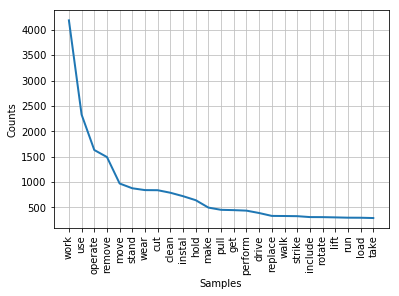

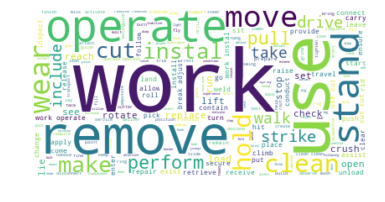

In [10]:
    if (ProcessMsiaDataSet):
        #Populate Activity Tokens for CaseItems and Categories
        for caseitem in MsiaCaseItems:
            caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
            for cat in MsiaCategories:
                if int(caseitem.CauseIndex) == int(cat.Index):
                    cat.ActivityTokensVerb += caseitem.ActivityTokensVerb + " "  
                    
        for cat in MsiaCategories:
            if (len(cat.ActivityTokensVerb.replace(" ",""))>0):
                print(cat.Name)
                explore(cat.ActivityTokensVerb)
    else:
        OshaVerb = ""              
        for caseitem in OshaCaseItems:
            caseitem.ActivityTokensChunk, caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
            OshaVerb += caseitem.ActivityTokensVerb + " "
        explore(OshaVerb)


In [11]:
    print("Extraction Chunk Count is " +  str(extract_chunk_count))
    print("Extraction Verb Count is " +  str(extract_verb_count))    


Extraction Chunk Count is 200
Extraction Verb Count is 179
